# 3D-MOT - Paper Figures - Time Domain
More exploratory code and figures, with full breakdown of the data is available in the Exploratory Folder.
This notebook 'hardcode' the code for each figure.
This code isn't meant to be pretty and scalable, but rather easy to manipulate to generate specific figures.

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
import copy
import time
import scipy.stats as stats
from tqdm import tqdm

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf, concatenate_raws
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import collections
from autoreject import AutoReject

from joblib import Parallel, delayed

import sys

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

#mne.viz.set_3d_backend('pyvistaqt')

In [138]:
#==================================================================
# General Variables
#==================================================================
# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
trigger = 2

conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

# Making Custom Triggers and Event ID
# ------------------------------------
custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]
# ------------------------------------

# Channels & Clusters of Channels
# ------------------------------------
channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 
       'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
       'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 
       'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 
       'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

clusters_chs = dict()
clusters_chs['Frontal'] = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'Fpz', 
                       'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8',  'FT8']
clusters_chs['Central']  = ['C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'Cz', 'CP5', 'CP3', 'CP1', 
                        'CPz', 'CP6', 'CP4', 'CP2', 'FC5', 'FC3', 'FC1', 'FC6', 'FC4', 'FC2']
clusters_chs['Temporal'] = ['FT7', 'T7', 'TP7', 'FT8', 'T8', 'TP8']
clusters_chs['Parietal'] = ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 
                        'POz', 'Pz', 'CPz', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4']
clusters_chs['Occipital'] = ['O1', 'Oz', 'POz','O2']

clusters_names = {'F':'Frontal', 'P':'Parietal', 'C':'Central', 'O':'Occipital', 'T':'Temporal'}
# ------------------------------------

# 3D-MOT Phases Information
phases = ['ID', 'Tracking', 'Recall']
stimx = {'ID':0, 'Tracking':2, 'Recall':11}
time_windows = {'ID':(-.2,2), 'Tracking':(1.5, 11), 'Recall':(10.5, 18)}

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.2)

# Folders & Paths
# directory_src = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/src/'
# directory_data = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Data/'
# directory_preproc = '/Users/nick/Documents/PhD/CLCT/NeuroTracker/Paper/data/'
directory_src = 'D:\\PhD\\NeuroTracker - Paper\\src\\'
directory_data = 'F:\\CAE - NeuroTracker\\Data\\'
directory_preproc = 'D:\\PhD\\NeuroTracker - Paper\\data\\'


# 1. Load Clean Epochs

Loading: Subject_F12F2_cleanAR.pkl...
61 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


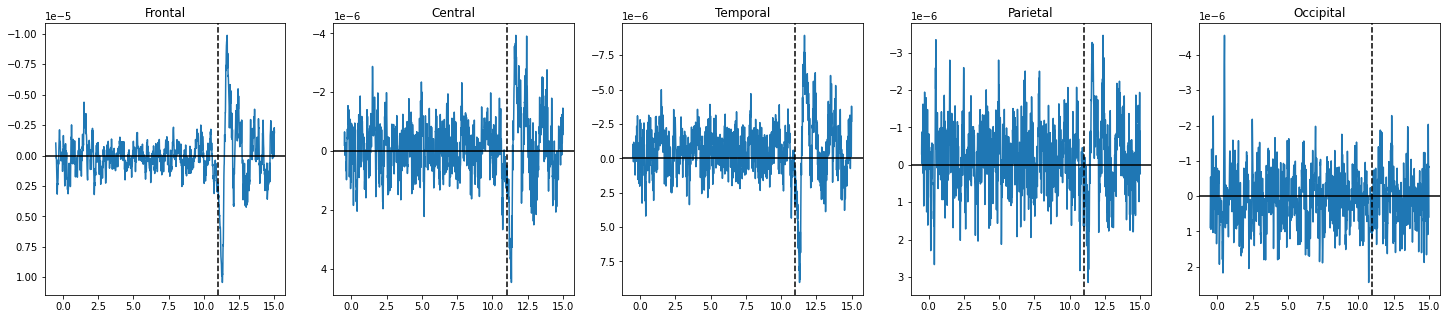

Subject Subject_F12F2_cleanAR Done! (36.31s)
Loading: Subject_F12M1_cleanAR.pkl...
77 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


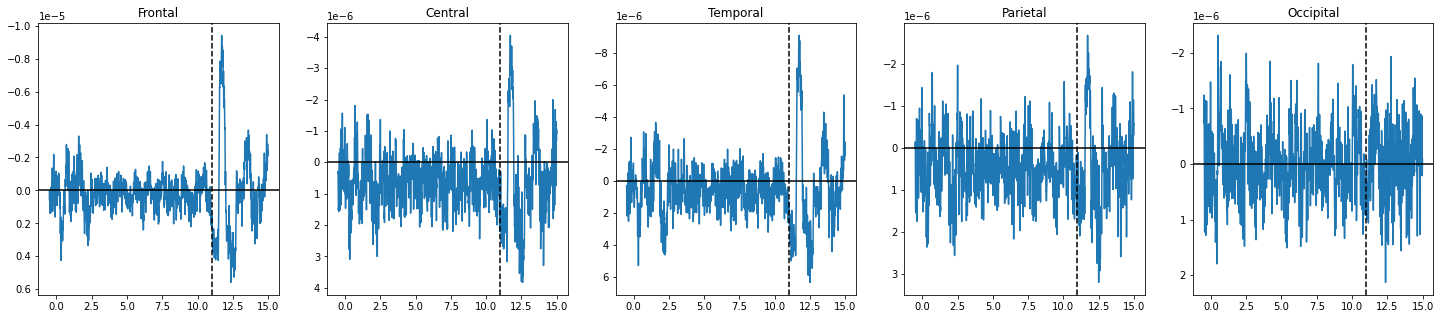

Subject Subject_F12M1_cleanAR Done! (54.69s)
Loading: Subject_F19M1_cleanAR.pkl...
55 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


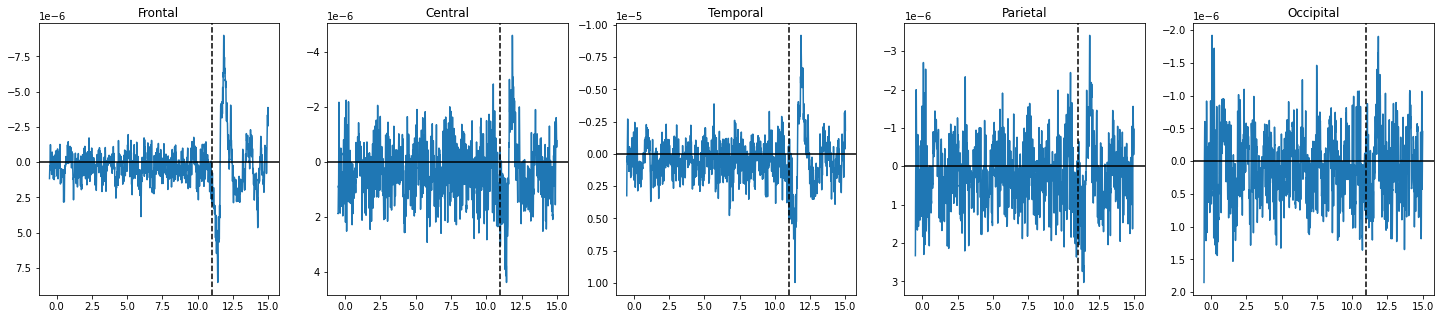

Subject Subject_F19M1_cleanAR Done! (43.11s)
Loading: Subject_F26F2_cleanAR.pkl...
39 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


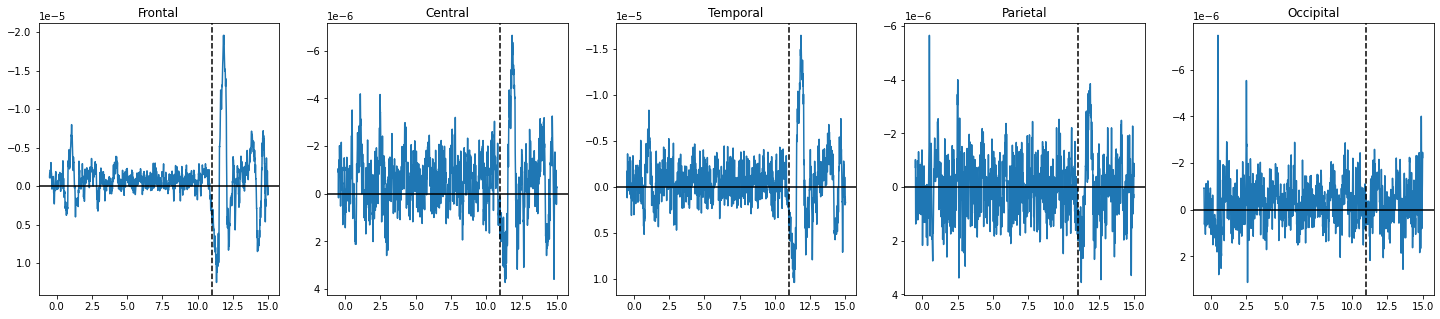

Subject Subject_F26F2_cleanAR Done! (28.65s)
Loading: Subject_F5M1_cleanAR.pkl...
24 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


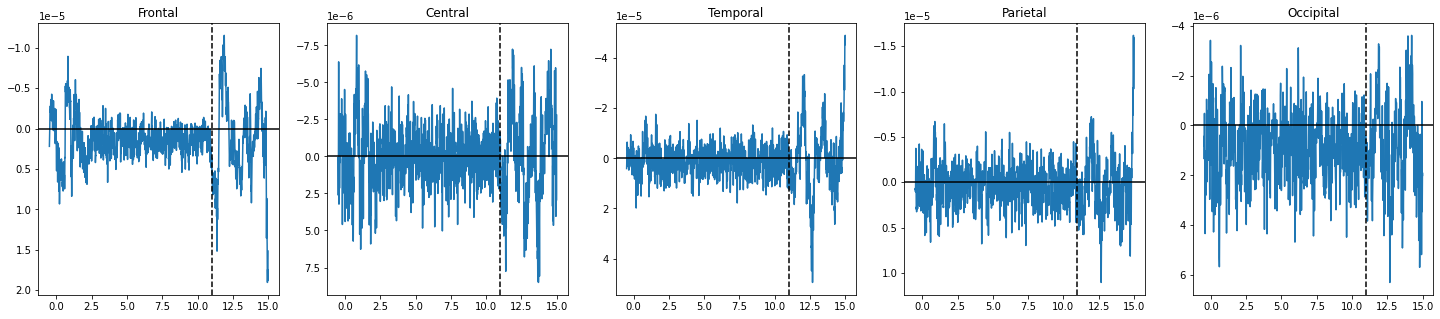

Subject Subject_F5M1_cleanAR Done! (19.70s)
Loading: Subject_M22F2_cleanAR.pkl...
65 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


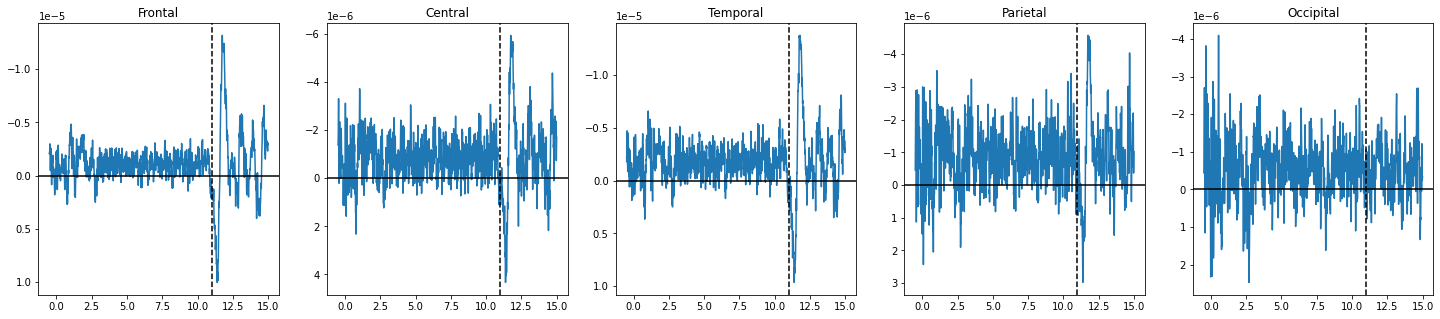

Subject Subject_M22F2_cleanAR Done! (52.57s)
Loading: Subject_M8M1_cleanAR.pkl...
83 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


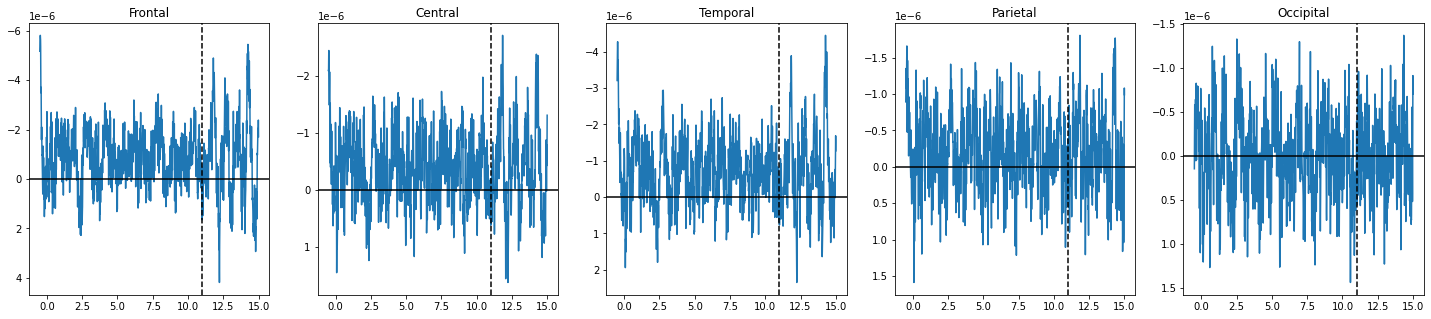

Subject Subject_M8M1_cleanAR Done! (65.48s)
Loading: Subject_M8M2_cleanAR.pkl...
82 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


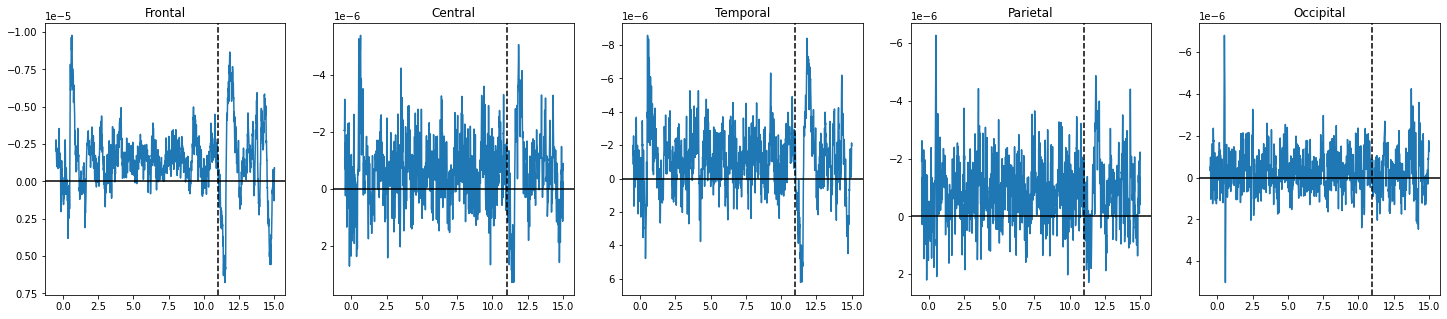

Subject Subject_M8M2_cleanAR Done! (65.21s)
Loading: Subject_S20M1_cleanAR.pkl...
78 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


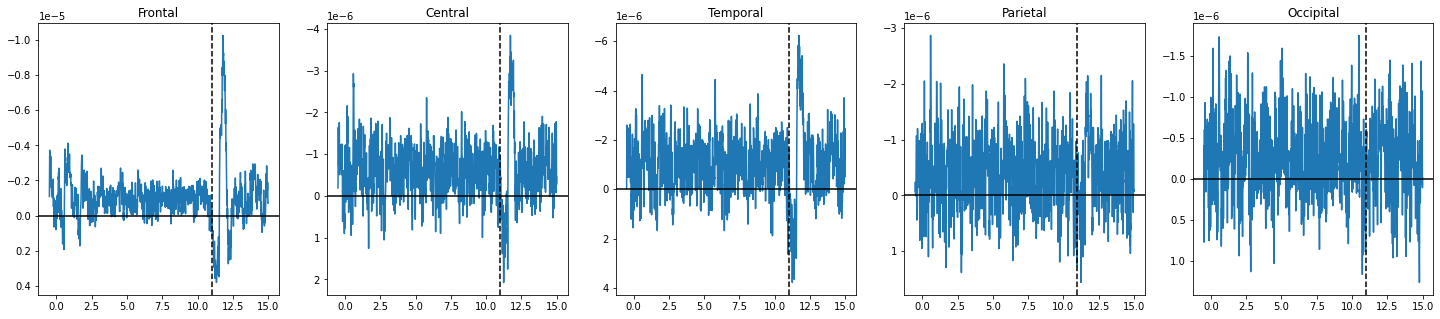

Subject Subject_S20M1_cleanAR Done! (64.08s)
Loading: Subject_S21F1_cleanAR.pkl...
94 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


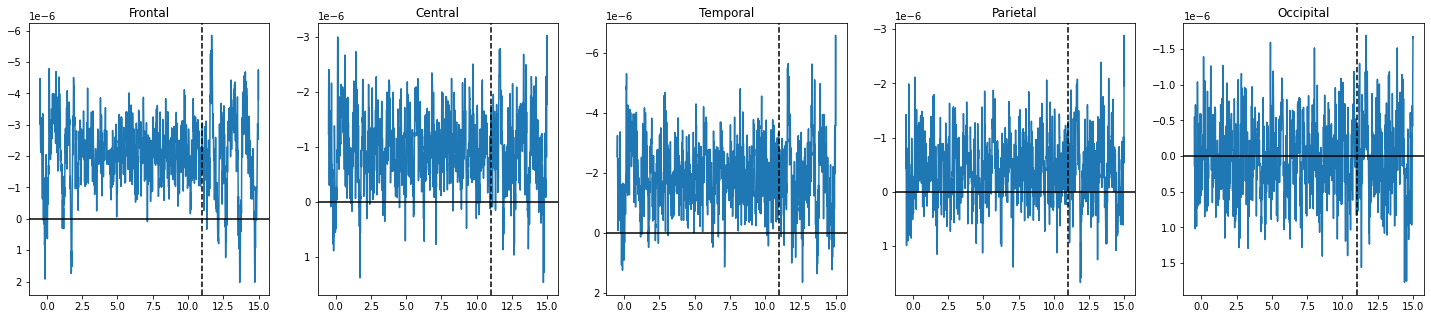

Subject Subject_S21F1_cleanAR Done! (73.85s)
Loading: Subject_T11F1_cleanAR.pkl...
68 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-8-3b5e84c91d3d>:70: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
<ipython-input-8-3b5e84c91d3d>:71: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\nu

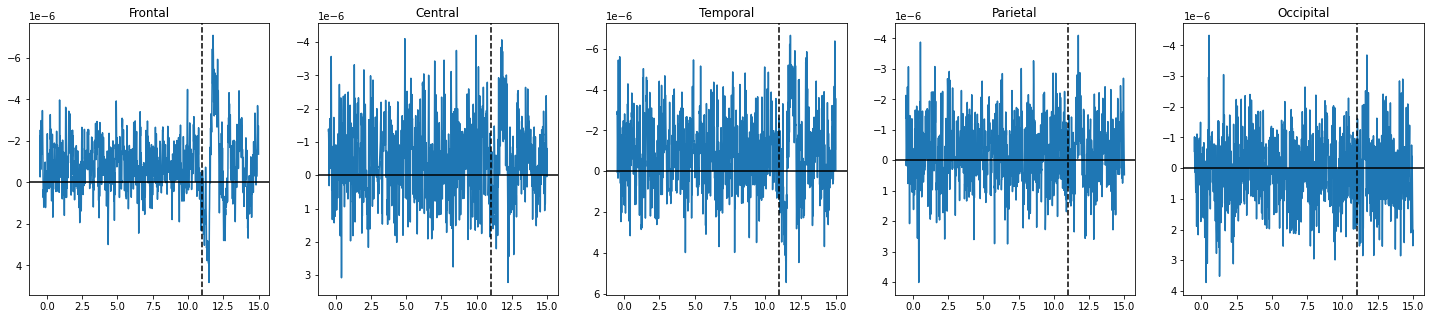

Subject Subject_T11F1_cleanAR Done! (50.72s)
Loading: Subject_T16F2_cleanAR.pkl...
75 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


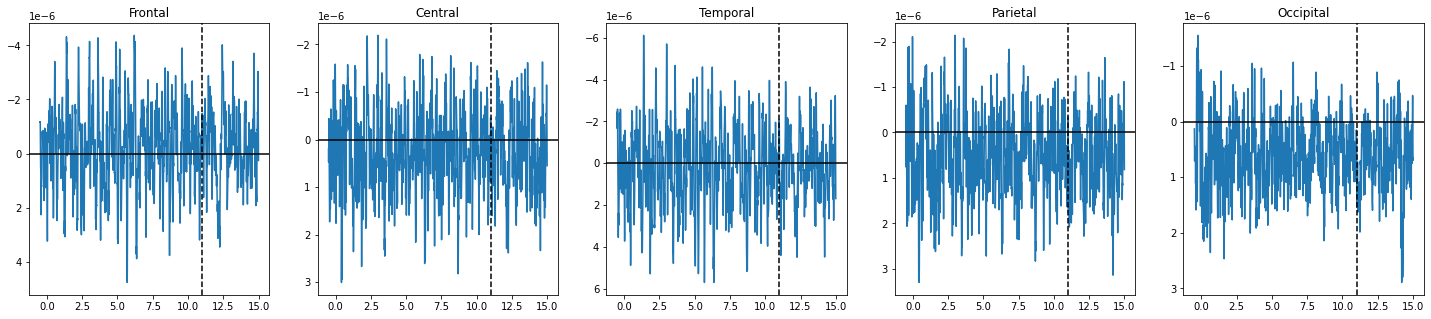

Subject Subject_T16F2_cleanAR Done! (61.58s)
Loading: Subject_T18F2_cleanAR.pkl...
27 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


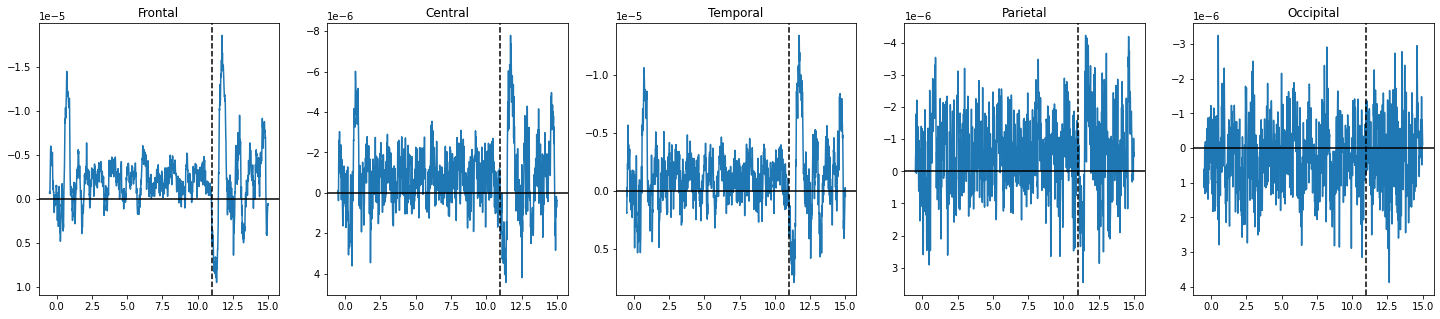

Subject Subject_T18F2_cleanAR Done! (25.97s)
Loading: Subject_T18M1_cleanAR.pkl...
74 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


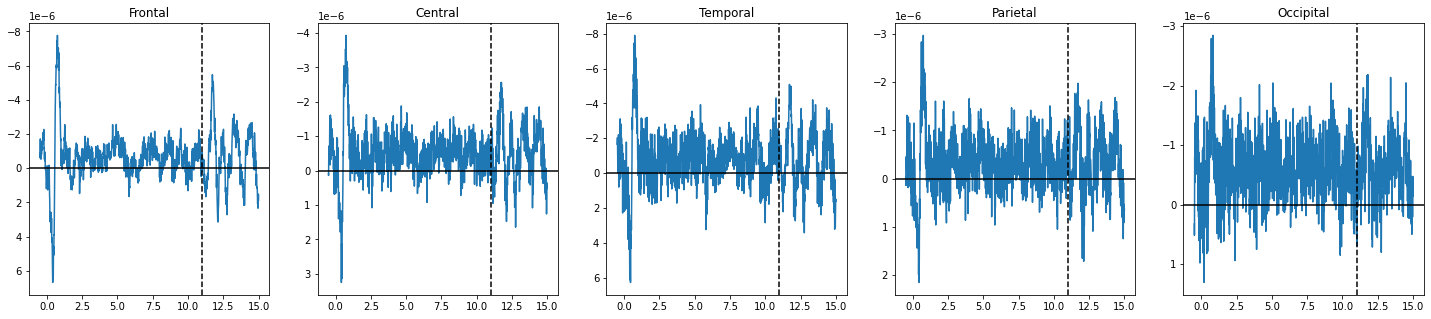

Subject Subject_T18M1_cleanAR Done! (64.85s)
Loading: Subject_T23F1_cleanAR.pkl...
79 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


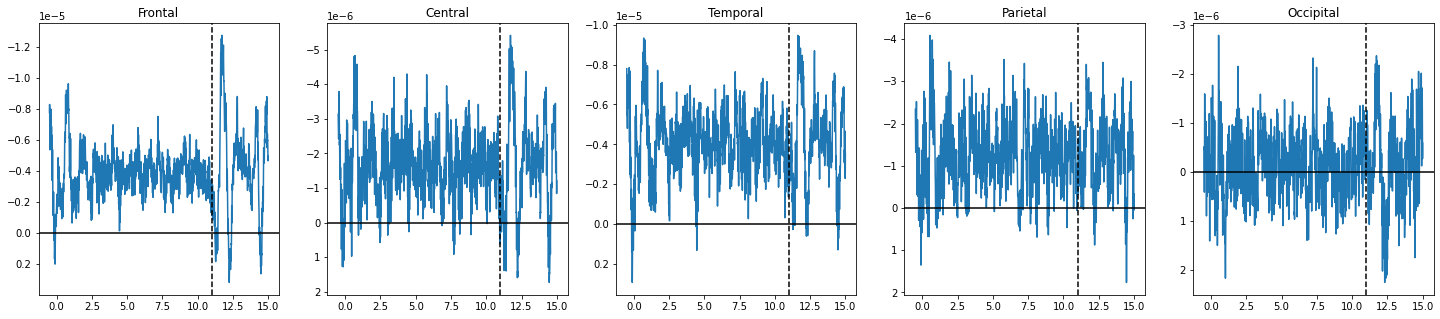

Subject Subject_T23F1_cleanAR Done! (55.41s)
Loading: Subject_T23F2_cleanAR.pkl...
81 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


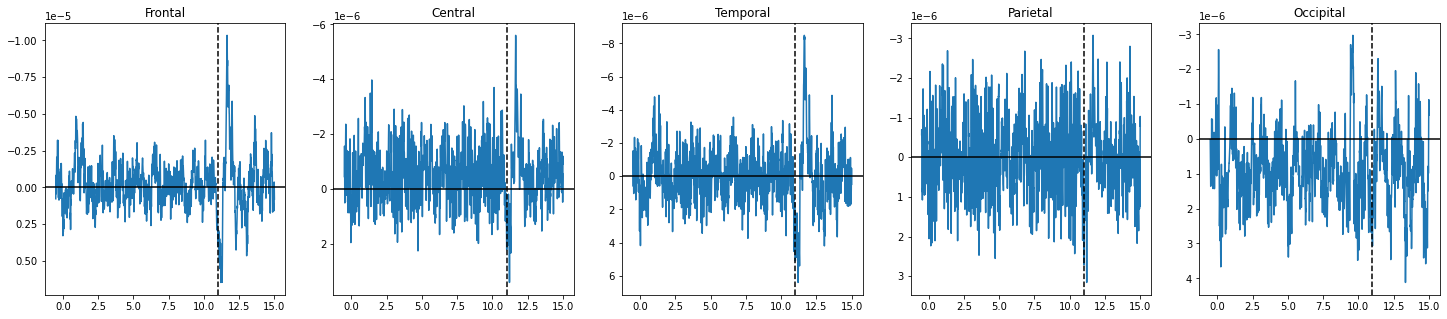

Subject Subject_T23F2_cleanAR Done! (63.62s)
Loading: Subject_T25F1_cleanAR.pkl...
84 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


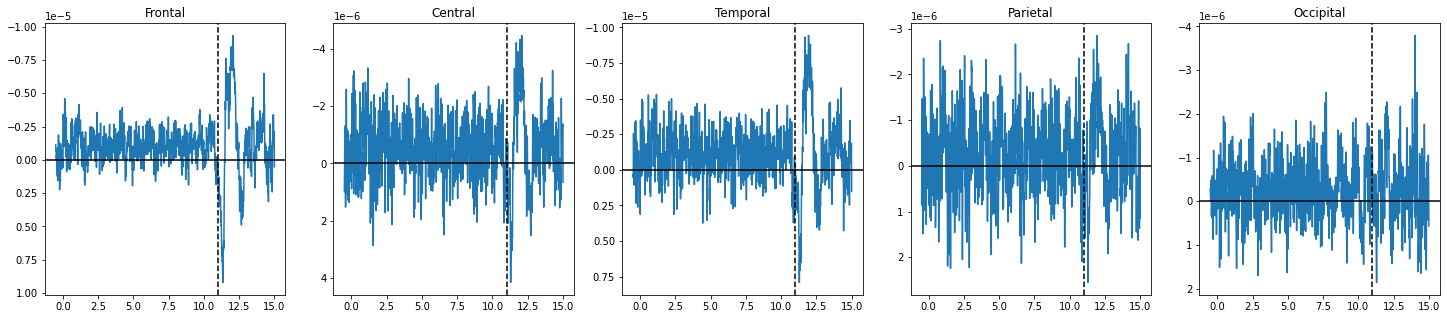

Subject Subject_T25F1_cleanAR Done! (58.04s)
Loading: Subject_T9F2_cleanAR.pkl...
50 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


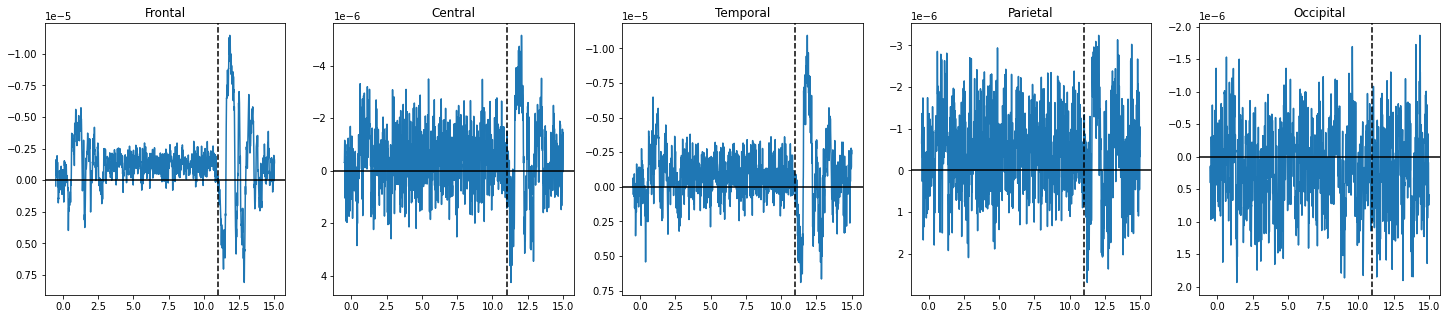

Subject Subject_T9F2_cleanAR Done! (43.63s)
Loading: Subject_W10F2_cleanAR.pkl...
70 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


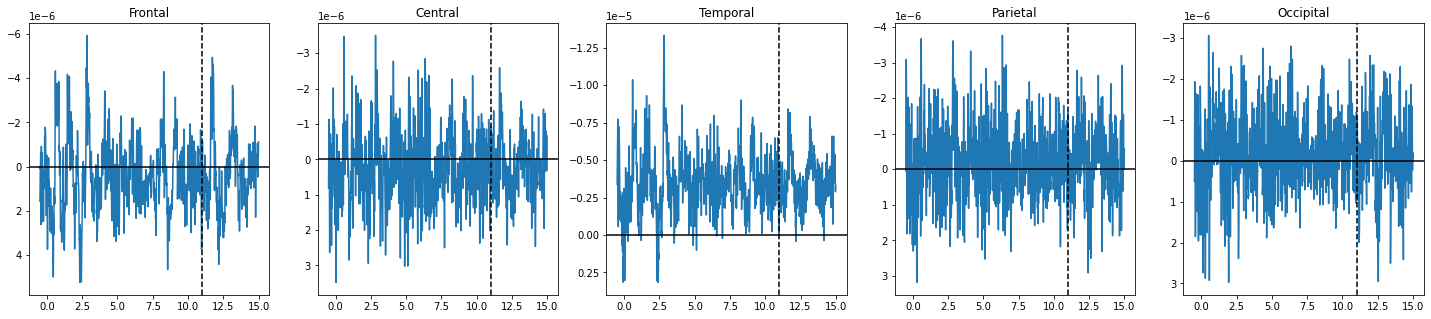

Subject Subject_W10F2_cleanAR Done! (54.95s)
Loading: Subject_W17M2_cleanAR.pkl...
83 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


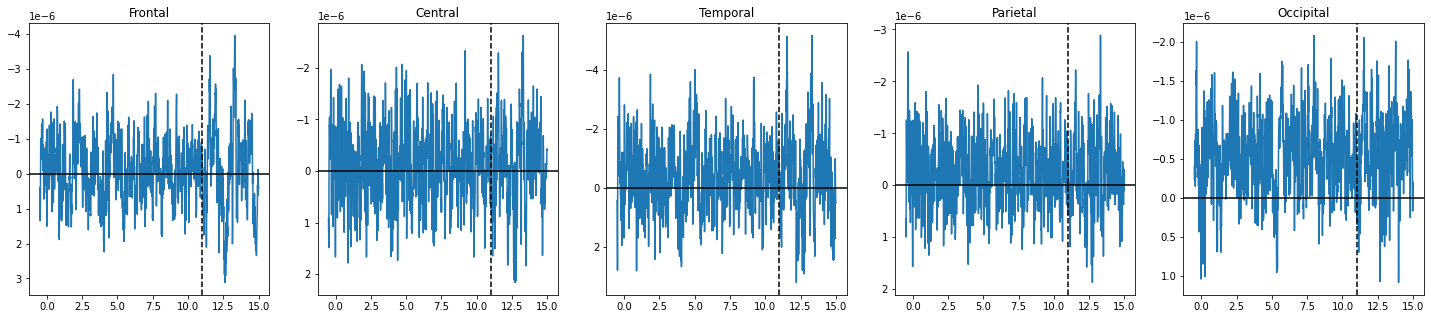

Subject Subject_W17M2_cleanAR Done! (63.04s)


In [8]:
CDA_lat_all = dict()  # Lateralized Activity for lateralized Trials
CM_all = dict()       # Lateralized Activity for Classic Mode Trials
CDA_ss_all = dict()   # CDA for Set Sizes

error_msg = ""
#=============================================================================
# Main Loop - Loading Files 1 by 1 to get CDA per Cluster per Subject.
#=============================================================================
for filepath in glob.iglob(directory_preproc + 'cleanAR\\Subject_*_cleanAR.pkl'):
    filename = filepath[filepath.rfind('\\')+1:]
    CDA_lat_all[filename] = dict()
    CDA_ss_all[filename] = dict()
    CM_all[filename] = dict()
    
    tic = time.time()
    print(f'Loading: {filename}...')

    with open(filepath, "rb") as f:
        data_pickle = pickle.load(f)

    epochs = data_pickle['epochs']
    print('{} epochs loaded.'.format(len(epochs)))
    
    epochs = epochs.filter(1, 30)
    epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))

    perf = 'good'
    
    fig, axs = plt.subplots(1, 5, figsize=(25,5))
    for i, cur_cluster in enumerate(clusters_chs.keys()):
        CDA_lat_all[filename][cur_cluster] = dict()
        CDA_ss_all[filename][cur_cluster] = dict()
        CM_all[filename][cur_cluster] = dict()
        
        # Get Left and Right Channel in the cluster.
        clusters_chs_right = []
        clusters_chs_left = []
        for ch in clusters_chs[cur_cluster]:
            if ch[-1] != 'z':
                if int(ch[-1]) % 2 == 0:
                    clusters_chs_right.append(ch)
                else:
                    clusters_chs_left.append(ch)
            
        # Lateralized
        cur_cda_lat = dict()
        for side in sides:
            e_filter = side + '/' + perf if (perf == 'good' or perf == 'bad') else side
            cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
            cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()
            if side == 'right':
                cur_cda_lat[side] = (np.mean(cur_evoked_2.get_data(), 0) - np.mean(cur_evoked_1.get_data(), 0))
            else:
                cur_cda_lat[side] = (np.mean(cur_evoked_1.get_data(), 0) - np.mean(cur_evoked_2.get_data(), 0))

            if side != 'classicmod':
                CDA_lat_all[filename][cur_cluster][side] = cur_cda_lat[side]
            else:
                CM_all[filename][cur_cluster][side] = cur_cda_lat[side]

            times = cur_evoked_1.times
            
        # Set Sizes
        for size in conds:
            cur_cda_ss = dict()
            CDA_ss_all[filename][cur_cluster][size] = dict()
            for side in sides:
                e_filter = size + '/' + side + '/' + perf
                try:
                    cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
                    cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()
                    if side == 'right':
                        cur_cda_ss[side] = (np.mean(cur_evoked_2.get_data(), 0) - np.mean(cur_evoked_1.get_data(), 0))
                    else:
                        cur_cda_ss[side] = (np.mean(cur_evoked_1.get_data(), 0) - np.mean(cur_evoked_2.get_data(), 0))

                    CDA_ss_all[filename][cur_cluster][size][side] = cur_cda_ss[side]
                except:
                    error_msg = error_msg + f'[{filename}]: No {e_filter}.\n'
                
        #plt.plot(times, cur_cda_right, label='{} Right'.format(ch_pair), alpha=0.3)
        #axs[i].plot(times, cur_cda_left, label='{} Left'.format(ch_pair), alpha=0.3)
        #axs[i].plot(times, cur_cda_classic, label='{} Classic'.format(ch_pair), alpha=0.3)
        axs[i].plot(times, (cur_cda_lat[sides[0]] + cur_cda_lat[sides[1]])/2, label='CDA')
        axs[i].axvline(x=11, color ='k', linestyle='--')
        axs[i].axhline(y=0, color ='k', linestyle='-')
        axs[i].invert_yaxis()
        axs[i].set_title(cur_cluster)
        #plt.legend()
    
    plt.show()
    
    # Try to clear memory. It shouldn't change anything as I am re-allocating that space, but can't be bad...
    del data_pickle
    del epochs
    
    toc = time.time()
    print('Subject {} Done! ({:.2f}s)'.format(filename[:-4], toc-tic))

data_pickle = dict()
data_pickle['CDA_lat_all'] = CDA_lat_all
data_pickle['CDA_ss_all'] = CDA_ss_all
data_pickle['CM_all'] = CM_all
data_pickle['times'] = times
with open(directory_preproc + 'CDA/CDA_data.pkl',"wb") as f:
    pickle.dump(data_pickle, f, protocol=pickle.HIGHEST_PROTOCOL)

## R1 - Occipital ERPs
Figure X in the paper.

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]

Loading: Subject_F12F2_cleanAR.pkl...
61 epochs loaded.


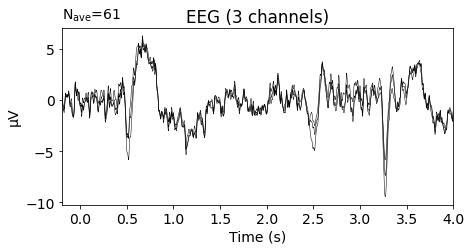

  5%|████▏                                                                              | 1/20 [00:23<07:26, 23.51s/it]
1it [00:23, 23.51s/it]

Subject Subject_F12F2_cleanAR Done! (23.51s)
Loading: Subject_F12M1_cleanAR.pkl...
77 epochs loaded.


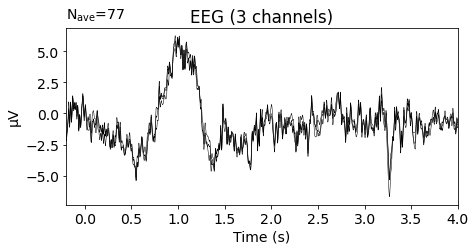

 10%|████████▎                                                                          | 2/20 [00:45<06:41, 22.33s/it]
2it [00:45, 22.33s/it]

Subject Subject_F12M1_cleanAR Done! (21.51s)
Loading: Subject_F19M1_cleanAR.pkl...
55 epochs loaded.


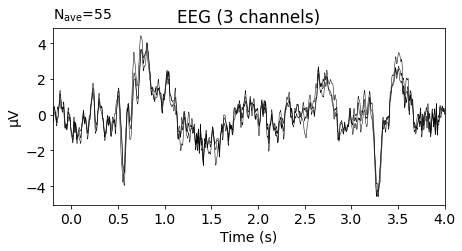

 15%|████████████▍                                                                      | 3/20 [01:00<05:23, 19.01s/it]
3it [01:00, 19.01s/it]

Subject Subject_F19M1_cleanAR Done! (15.06s)
Loading: Subject_F26F2_cleanAR.pkl...
39 epochs loaded.


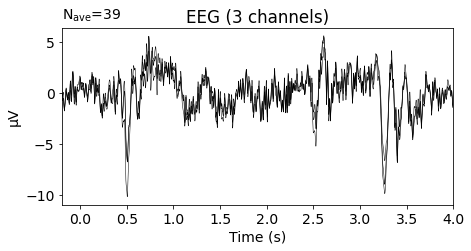

 20%|████████████████▌                                                                  | 4/20 [01:11<04:13, 15.85s/it]
4it [01:11, 15.85s/it]

Subject Subject_F26F2_cleanAR Done! (11.01s)
Loading: Subject_F5M1_cleanAR.pkl...
24 epochs loaded.


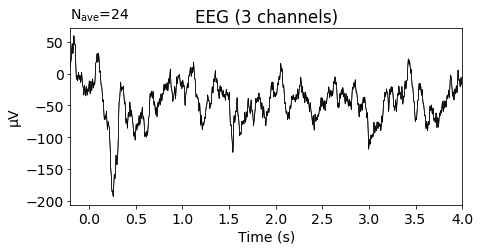

 25%|████████████████████▊                                                              | 5/20 [01:18<03:09, 12.65s/it]
5it [01:18, 12.65s/it]

Subject Subject_F5M1_cleanAR Done! (6.97s)
Loading: Subject_M22F2_cleanAR.pkl...
65 epochs loaded.


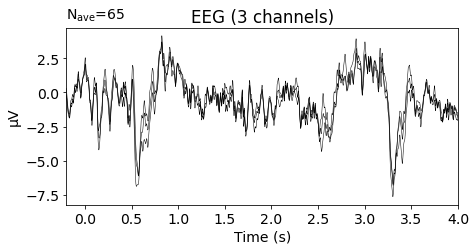

 30%|████████████████████████▉                                                          | 6/20 [01:36<03:23, 14.52s/it]
6it [01:36, 14.52s/it]

Subject Subject_M22F2_cleanAR Done! (18.16s)
Loading: Subject_M8M1_cleanAR.pkl...
83 epochs loaded.


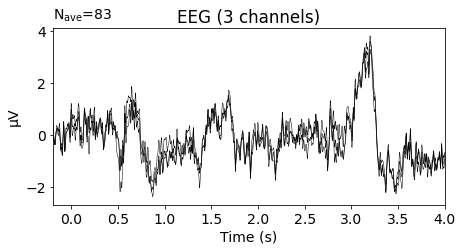

 35%|█████████████████████████████                                                      | 7/20 [01:59<03:45, 17.32s/it]
7it [01:59, 17.32s/it]

Subject Subject_M8M1_cleanAR Done! (23.08s)
Loading: Subject_M8M2_cleanAR.pkl...
82 epochs loaded.


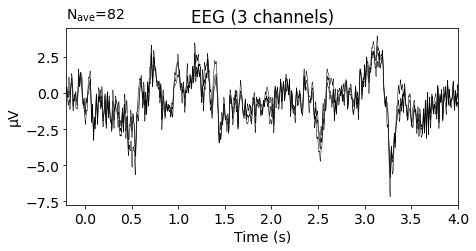

 40%|█████████████████████████████████▏                                                 | 8/20 [02:22<03:52, 19.34s/it]
8it [02:22, 19.34s/it]

Subject Subject_M8M2_cleanAR Done! (23.66s)
Loading: Subject_S20M1_cleanAR.pkl...
78 epochs loaded.


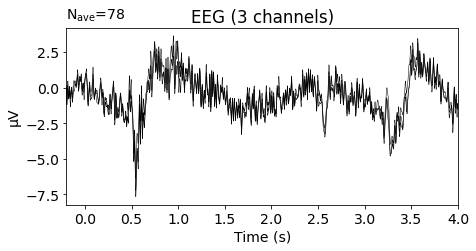

 45%|█████████████████████████████████████▎                                             | 9/20 [02:44<03:39, 19.98s/it]
9it [02:44, 19.98s/it]

Subject Subject_S20M1_cleanAR Done! (21.39s)
Loading: Subject_S21F1_cleanAR.pkl...
94 epochs loaded.


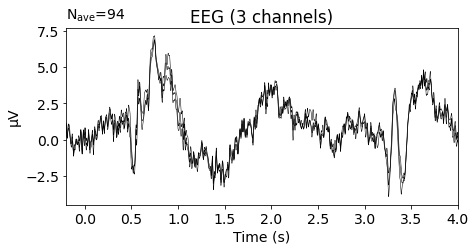

 50%|█████████████████████████████████████████                                         | 10/20 [03:10<03:38, 21.84s/it]
10it [03:10, 21.84s/it]

Subject Subject_S21F1_cleanAR Done! (25.99s)
Loading: Subject_T11F1_cleanAR.pkl...
68 epochs loaded.


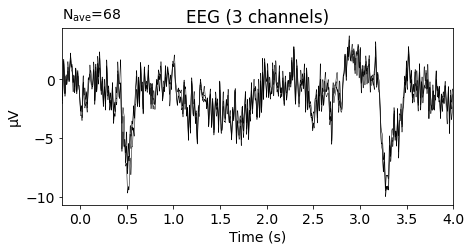

 55%|█████████████████████████████████████████████                                     | 11/20 [03:28<03:07, 20.81s/it]
11it [03:28, 20.81s/it]

Subject Subject_T11F1_cleanAR Done! (18.49s)
Loading: Subject_T16F2_cleanAR.pkl...
75 epochs loaded.


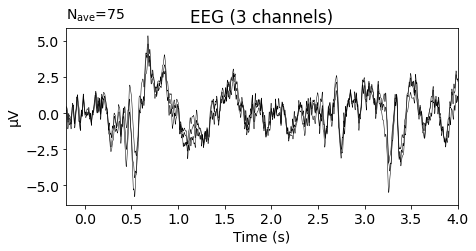

 60%|█████████████████████████████████████████████████▏                                | 12/20 [03:49<02:46, 20.86s/it]
12it [03:49, 20.86s/it]

Subject Subject_T16F2_cleanAR Done! (20.95s)
Loading: Subject_T18F2_cleanAR.pkl...
27 epochs loaded.


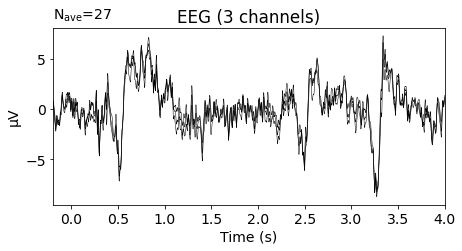

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:58<01:59, 17.08s/it]
13it [03:58, 17.08s/it]

Subject Subject_T18F2_cleanAR Done! (8.40s)
Loading: Subject_T18M1_cleanAR.pkl...
74 epochs loaded.


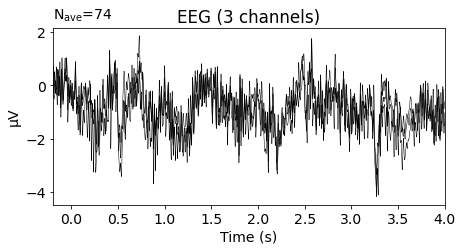

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [04:18<01:48, 18.07s/it]
14it [04:18, 18.07s/it]

Subject Subject_T18M1_cleanAR Done! (20.35s)
Loading: Subject_T23F1_cleanAR.pkl...
79 epochs loaded.


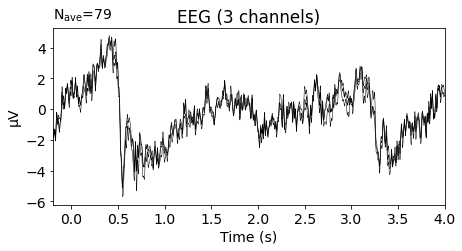

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [04:40<01:35, 19.16s/it]
15it [04:40, 19.16s/it]

Subject Subject_T23F1_cleanAR Done! (21.67s)
Loading: Subject_T23F2_cleanAR.pkl...
81 epochs loaded.


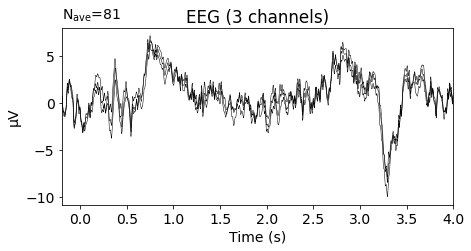

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [05:02<01:20, 20.07s/it]
16it [05:02, 20.07s/it]

Subject Subject_T23F2_cleanAR Done! (22.19s)
Loading: Subject_T25F1_cleanAR.pkl...
84 epochs loaded.


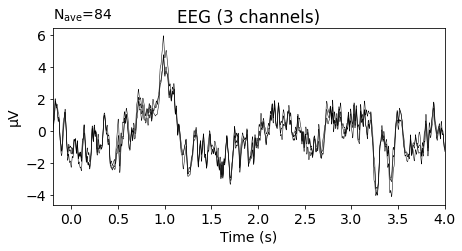

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [05:25<01:02, 20.95s/it]
17it [05:25, 20.95s/it]

Subject Subject_T25F1_cleanAR Done! (23.00s)
Loading: Subject_T9F2_cleanAR.pkl...
50 epochs loaded.


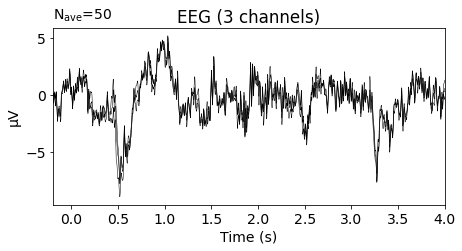

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [05:38<00:37, 18.73s/it]
18it [05:38, 18.73s/it]

Subject Subject_T9F2_cleanAR Done! (13.55s)
Loading: Subject_W10F2_cleanAR.pkl...
70 epochs loaded.


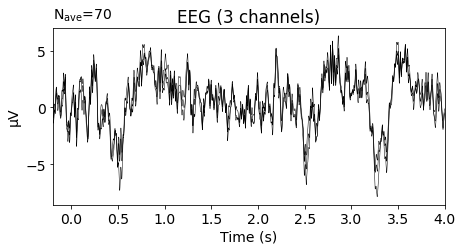

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [05:58<00:19, 19.03s/it]
19it [05:58, 19.03s/it]

Subject Subject_W10F2_cleanAR Done! (19.75s)
Loading: Subject_W17M2_cleanAR.pkl...
83 epochs loaded.


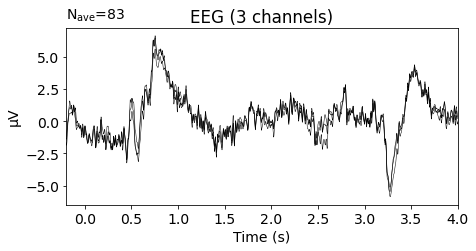

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:22<00:00, 20.40s/it]
20it [06:22, 19.12s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:22<00:00, 19.12s/it]

Subject Subject_W17M2_cleanAR Done! (23.58s)


In [139]:
data_dict = dict()

#=============================================================================
# Main Loop - Loading Files 1 by 1 to get CDA per Cluster per Subject.
#=============================================================================
nb_iterations = len(list(glob.iglob(directory_preproc + 'cleanAR\\Subject_*_cleanAR.pkl')))
pbar = tqdm(total=nb_iterations)
for filepath in tqdm(glob.iglob(directory_preproc + 'cleanAR\\Subject_*_cleanAR.pkl')):
    filename = filepath[filepath.rfind('\\')+1:]
    
    tic = time.time()
    print(f'Loading: {filename}...')

    with open(filepath, "rb") as f:
        data_pickle = pickle.load(f)

    epochs = data_pickle['epochs']
    print('{} epochs loaded.'.format(len(epochs)))
    
    epochs = epochs.filter(1, 50, verbose=False)
    epochs = epochs.apply_baseline(baseline=(-0.2, 0), verbose=False)
    
    #epochs.plot_image()
    #epochs.pick_channels(['O1', 'O2', 'Oz']).plot_image()
    
    epochs.pick_channels(['O1', 'O2', 'Oz'])
    cur_evoked = epochs.average()
    cur_evoked.copy().crop(tmin=-0.2, tmax=4).plot()
    
    times = cur_evoked.times
    
    data = cur_evoked.get_data().mean(0)
    data_dict[filename] = data
        
    # Try to clear memory. It shouldn't change anything as I am re-allocating that space, but can't be bad...
    del data_pickle
    del epochs
    
    toc = time.time()
    print('Subject {} Done! ({:.2f}s)'.format(filename[:-4], toc-tic))
    
    pbar.update(1)
pbar.close()

data_pickle = dict()
data_pickle['data_dict'] = data_dict
data_pickle['times'] = times
with open(directory_preproc + 'ERPs/Occipital_ERPs.pkl',"wb") as f:
    pickle.dump(data_pickle, f, protocol=pickle.HIGHEST_PROTOCOL)

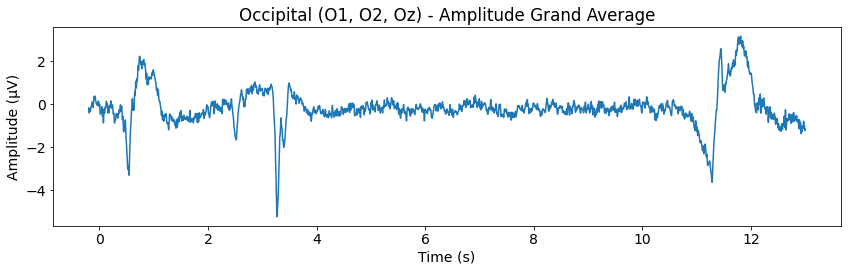

In [140]:
fig = plt.figure(figsize=(12,4))
data_all = []
for participant in data_dict.keys():
    if participant == 'Subject_F5M1_cleanAR.pkl':
        continue
    data_all.append(data_dict[participant])
data_all = np.stack(data_all)
data_all_mean = np.mean(data_all, 0)

times_window = (times > -0.2) & (times <= 13)
plt.plot(times[times_window], data_all_mean[times_window] * 1e6)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.title('Occipital (O1, O2, Oz) - Amplitude Grand Average')

plt.tight_layout()
plt.show()

fig.savefig('R4 Time - Occipital ERPs.png', dpi=300, format='png')

## R2 - Lateralized Activity: ID & Recall (SS=All, Perf=Good)
Figure X in the paper.

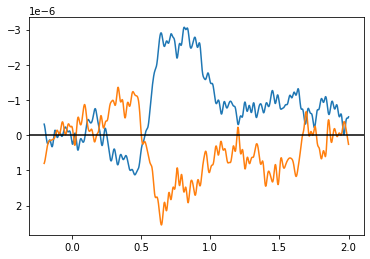

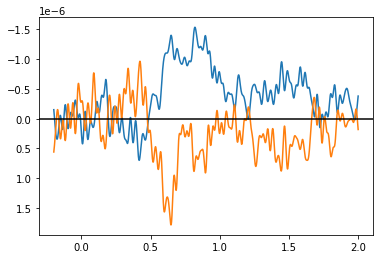

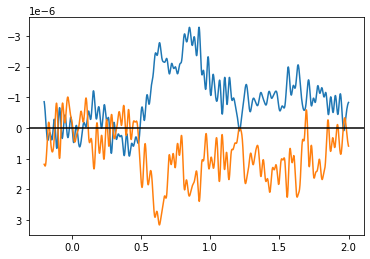

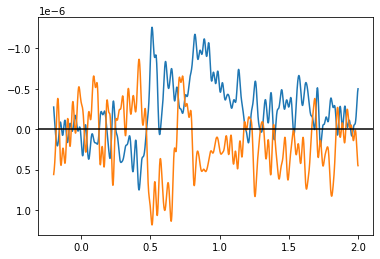

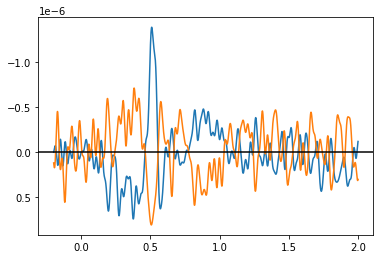

In [11]:
for cur_cluster in clusters_chs.keys(): 
    cda_stacked = []
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['left'])
    CDA_all_stacked_left = np.stack(cda_stacked)
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['right'])
    CDA_all_stacked_right = np.stack(cda_stacked)

    #CDA_all_stacked = np.stack(CDA_all)
    CDA_all_mean_right = np.mean(CDA_all_stacked_right, 0)
    CDA_all_mean_left = np.mean(CDA_all_stacked_left, 0)

    time_window = (times >= -0.2) & (times <= 2)
    plt.plot(times[time_window], CDA_all_mean_right[time_window], label='CDA')
    plt.plot(times[time_window], -1.0 * CDA_all_mean_left[time_window], label='CDA')
    #plt.axvline(x=11, color ='k', linestyle='--')
    plt.axhline(y=0, color ='k', linestyle='-')
    plt.gca().invert_yaxis()
    #plt.legend()
    plt.show()

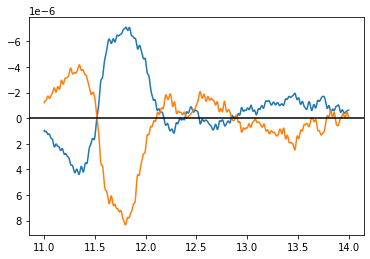

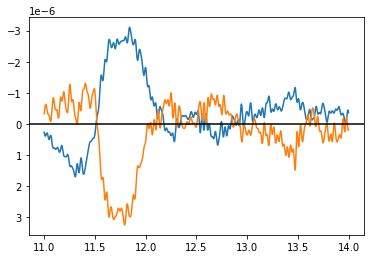

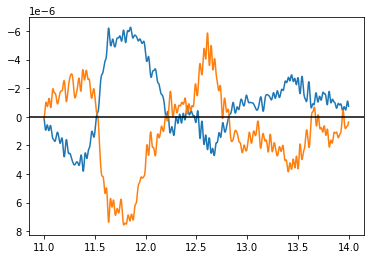

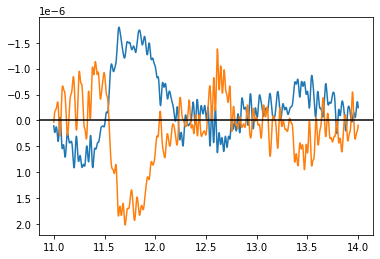

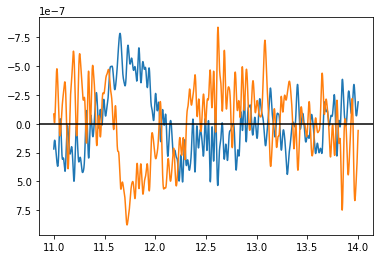

In [70]:
for cur_cluster in clusters_chs.keys(): 
    cda_stacked = []
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['left'])
    CDA_all_stacked_left = np.stack(cda_stacked)
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['right'])
    CDA_all_stacked_right = np.stack(cda_stacked)

    #CDA_all_stacked = np.stack(CDA_all)
    CDA_all_mean_right = np.mean(CDA_all_stacked_right, 0)
    CDA_all_mean_left = np.mean(CDA_all_stacked_left, 0)

    time_window = (times >= 11) & (times <= 14)
    plt.plot(times[time_window], CDA_all_mean_right[time_window], label='CDA')
    plt.plot(times[time_window], -1.0 * CDA_all_mean_left[time_window], label='CDA')
    #plt.axvline(x=11, color ='k', linestyle='--')
    plt.axhline(y=0, color ='k', linestyle='-')
    plt.gca().invert_yaxis()
    #plt.legend()
    plt.show()

## R2 - Lateralized Activity: Full Sequence (SS=All, Perf=Good)
Figure X in the paper.

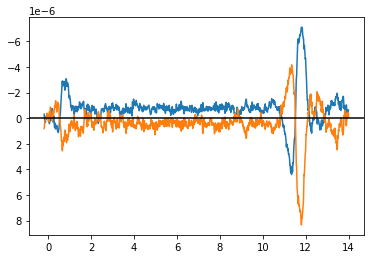

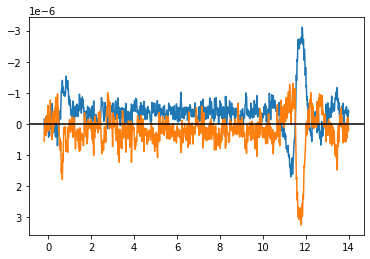

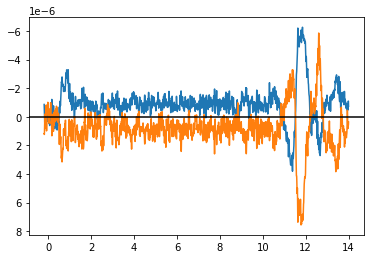

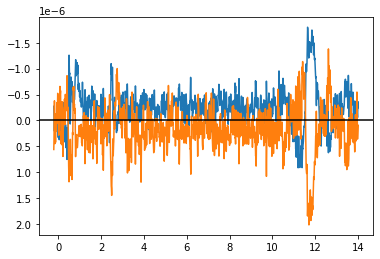

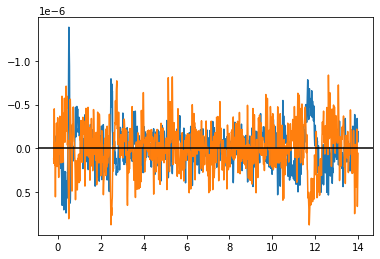

In [64]:
for cur_cluster in clusters_chs.keys(): 
    cda_stacked = []
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['left'])
    CDA_all_stacked_left = np.stack(cda_stacked)
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['right'])
    CDA_all_stacked_right = np.stack(cda_stacked)

    #CDA_all_stacked = np.stack(CDA_all)
    CDA_all_mean_right = np.mean(CDA_all_stacked_right, 0)
    CDA_all_mean_left = np.mean(CDA_all_stacked_left, 0)

    time_window = (times >= -0.2) & (times <= 14)
    plt.plot(times[time_window], CDA_all_mean_right[time_window], label='CDA')
    plt.plot(times[time_window], -1.0 * CDA_all_mean_left[time_window], label='CDA')
    #plt.axvline(x=11, color ='k', linestyle='--')
    plt.axhline(y=0, color ='k', linestyle='-')
    plt.gca().invert_yaxis()
    #plt.legend()
    plt.show()

# LAT - from Raw, cuz F.

In [123]:
total_subjects = 0
total_trials = 0

CDA_lat_all = dict()
#==================================================================
# Main Loop - Loading All Files & Saving Clean Epochs.
#==================================================================
pbar = tqdm(total=20)
for filepath in glob.iglob(directory_data + '*.bdf'):
    filename = filepath[filepath.rfind('\\')+1:]
    
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    tic = time.time()
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M1_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M1_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M2_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M2_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'T9F2_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'T9M1_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'    

    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})
    
    # TODO: DOUBLE CHECK THE EXG4, EXG5 QUALITY ON ALL PARTICIPANTS.

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # TODO: Manual Intervention or not?
    # Bad channels - manual removal...
    # Subject T23F1.bdf: PO4
    # Subject T18F2.bdf: Iz
    #raw = raw.drop_channels('PO4')
    #raw = raw.drop_channels('Iz')

    # Sampling Frequency
    sfreq = raw.info['sfreq']

    # Events 
    events = find_events(raw)

    # Load Behav Data.
    df_behav = pd.read_csv(directory_data + filename[:filename.rfind('.')] + '.csv', sep=',')

    # Rework Events based on Behav Data. (to add Side and SetSize information)
    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            #if (nb_trials + 1) % 10 == 0:
                #print('Check Synch!')

    # Working with modified events from now on.
    events = new_events
    
    total_trials = total_trials + nb_trials
    print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

    # Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
    print('==================================================')
    print('Removing Events ID not in EEG File...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events)[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================') 
    
    # Calculate average response time.
    resp_time_in_ticks = []
    for i, e in enumerate(events):
        if e[2] == 8:
            if events[i+1,2] == 32:
                resp_time_in_ticks.append(events[i+1,0] - events[i,0])
            elif events[i+1,2] == 16: #Synch?!
                if events[i+2,2] == 32:
                    resp_time_in_ticks.append(events[i+2,0] - events[i,0])
                else:
                    print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))
            else:
                print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))

    mean_rt = np.mean(resp_time_in_ticks)
    median_rt = np.median(resp_time_in_ticks)
    std_rt = np.std(resp_time_in_ticks)
    print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))
        
    # Epoching
    # TODO: take values from const.
    epochs = Epochs(raw, events, event_id=cur_event_id, tmin=-2, tmax=15, baseline=(-1, -0.2), preload=True, event_repeated='merge', on_missing='warn')
    
    epochs = epochs.filter(1, 30)
    #epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))
    
    # Cleaning
    #ar = AutoReject(n_jobs=10)
    #epochs, reject_log = ar.fit_transform(epochs, return_log=True) 
    #fig, ax = plt.subplots(figsize=(15,8))
    #reject_log.plot('horizontal', ax=ax)
    
    # Save Clean Epochs for each Participant.
    #data_pickle = dict()
    #data_pickle['events'] = events
    #data_pickle['epochs'] = epochs
    #with open(directory_preproc + f"cleanAR/Subject_{filename[:-4]}_cleanAR.pkl","wb") as f:
    #    pickle.dump(data_pickle, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    CDA_lat_all[filename] = dict()
    for cluster in clusters_chs.keys():
        CDA_lat_all[filename][cluster] = dict()
        
        # Get Left and Right Channel in the cluster.
        clusters_chs_right = []
        clusters_chs_left = []
        for ch in clusters_chs[cluster]:
            if ch[-1] != 'z':
                if int(ch[-1]) % 2 == 0:
                    clusters_chs_right.append(ch)
                else:
                    clusters_chs_left.append(ch)
            
        for side in ['left', 'right']:
            e_filter = side + '/' + 'good'
            try:
                cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
                cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()
                if side == 'right':
                    cur_cda = (np.mean(cur_evoked_2.get_data(), 0) - np.mean(cur_evoked_1.get_data(), 0))
                else:
                    cur_cda = (np.mean(cur_evoked_1.get_data(), 0) - np.mean(cur_evoked_2.get_data(), 0))

                CDA_lat_all[filename][cluster][side] = cur_cda

                times = cur_evoked_1.times

            except:
                print(f'Skipping... {filename} - {size} - {side}')

    total_subjects = total_subjects + 1
    
    toc = time.time()
    print('Subject {} Done! ({:.2f}s)'.format(filename[:-4], toc-tic))
    
    pbar.update(1)
    
pbar.close() 
print(f'{total_subjects} Participants with a total of {total_trials}.')

data_pickle = dict()
data_pickle['CDA_lat_all'] = CDA_lat_all
data_pickle['times'] = times
with open(directory_preproc + 'CDA/Lateralized_data_raw.pkl',"wb") as f:
    pickle.dump(data_pickle, f)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Processing: F12F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



  5%|████▏                                                                              | 1/20 [00:39<12:23, 39.15s/it]

Subject F12F2 Done! (39.15s)
Processing: F12M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F12M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5881855  =      0.000 ...  2872.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 10%|████████▎                                                                          | 2/20 [01:19<11:58, 39.94s/it]

Subject F12M1 Done! (40.48s)
Processing: F19M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F19M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7309311  =      0.000 ...  3569.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 15%|████████████▍                                                                      | 3/20 [02:05<12:05, 42.70s/it]

Subject F19M1 Done! (45.99s)
Processing: F26F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F26F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3024895  =      0.000 ...  1477.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
237 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 42 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Event: 3/right/good (311), not present.
Response Time ~nans (std:nan)
Not setting metadata
42 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 eve

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 20%|████████████████▌                                                                  | 4/20 [02:26<09:03, 33.95s/it]

Subject F26F2 Done! (20.53s)
Processing: F5M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F5M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3280895  =      0.000 ...  1602.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
258 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 42 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Event: 2/classicmod/bad (232), not present.
Event: 3/right/bad (312), not present.
Event: 3/left/good (321), not present.
Response Time ~nans (std:nan)
Not setting metadata
42 matching events found
Applying baseline correction (m

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 25%|████████████████████▊                                                              | 5/20 [02:46<07:14, 28.96s/it]

Subject F5M1 Done! (20.12s)
Processing: M22F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M22F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6383615  =      0.000 ...  3117.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 30%|████████████████████████▉                                                          | 6/20 [03:27<07:44, 33.16s/it]

Subject M22F2 Done! (41.30s)
Processing: M8M1_B1-B2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M1_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4220927  =      0.000 ...  2061.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M1_B3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3491839  =      0.000 ...  1705.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M1_B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535999  =      0.000 ...   750.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
645 events found
Event IDs: [    1     2     4 

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 35%|█████████████████████████████                                                      | 7/20 [04:25<08:56, 41.29s/it]

Subject M8M1 Done! (58.03s)
Processing: M8M2_B1-B2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M2_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3672063  =      0.000 ...  1793.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M2_B3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1574911  =      0.000 ...   769.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M2_B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1384447  =      0.000 ...   676.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
518 events found
Event IDs: [    1     2     4  

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 40%|█████████████████████████████████▏                                                 | 8/20 [05:09<08:26, 42.19s/it]

Subject M8M2 Done! (44.11s)
Processing: S20M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\S20M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948863  =      0.000 ...  3393.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 2/classicmod/bad (232), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 45%|█████████████████████████████████████▎                                             | 9/20 [05:53<07:49, 42.68s/it]

Subject S20M1 Done! (43.75s)
Processing: S21F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\S21F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7776255  =      0.000 ...  3797.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
576 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 94 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Response Time ~nans (std:nan)
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 94 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 50%|█████████████████████████████████████████                                         | 10/20 [06:42<07:25, 44.51s/it]

Subject S21F1 Done! (48.62s)
Processing: T11F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T11F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5885951  =      0.000 ...  2874.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 55%|█████████████████████████████████████████████                                     | 11/20 [07:20<06:24, 42.71s/it]

Subject T11F1 Done! (38.63s)
Processing: T16F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T16F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5064703  =      0.000 ...  2473.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
459 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 75 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Response Time ~nans (std:nan)
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 75 events and 34817 original time points

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 60%|█████████████████████████████████████████████████▏                                | 12/20 [07:57<05:27, 40.99s/it]

Subject T16F2 Done! (37.04s)
Processing: T18F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T18F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6344703  =      0.000 ...  3098.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [08:41<04:53, 41.87s/it]

Subject T18F2 Done! (43.90s)
Processing: T18M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T18M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6027263  =      0.000 ...  2943.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 eve

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [09:26<04:17, 42.89s/it]

Subject T18M1 Done! (45.23s)
Processing: T23F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T23F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6590463  =      0.000 ...  3218.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [10:09<03:34, 42.89s/it]

Subject T23F1 Done! (42.91s)
Processing: T23F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T23F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6369279  =      0.000 ...  3110.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [10:52<02:51, 42.88s/it]

Subject T23F2 Done! (42.85s)
Processing: T25F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T25F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7065599  =      0.000 ...  3450.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [11:34<02:08, 42.69s/it]

Subject T25F1 Done! (42.25s)
Processing: T9F2_B1-B2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T9F2_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3352575  =      0.000 ...  1637.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T9F2_B3-B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3555327  =      0.000 ...  1736.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
517 events found
Event IDs: [    1     2     4     8    16    32 65536]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Response Time

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [12:25<01:30, 45.06s/it]

Subject T9F2 Done! (50.59s)
Processing: W10F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\W10F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6434815  =      0.000 ...  3142.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [13:17<00:47, 47.07s/it]

Subject W10F2 Done! (51.73s)
Processing: W17M2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\W17M2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7319551  =      0.000 ...  3574.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
513 events found
Event IDs: [    1     2     4     8    16    32 65540]
A total of 83 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 83 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:18<00:00, 42.95s/it]

Subject W17M2 Done! (61.65s)
20 Participants with a total of 1617.


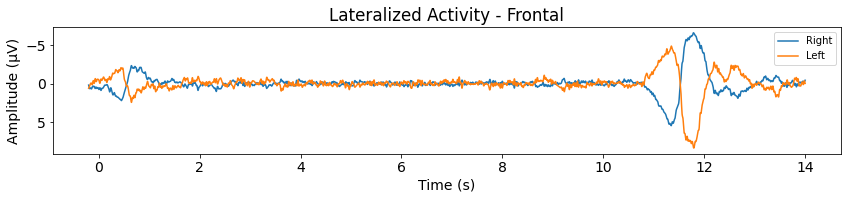

In [136]:
time_window = (times >= -0.2) & (times <= 14)

plt.rcParams.update({'font.size':14})
fig = plt.figure(figsize=(12, 3))

cda_stacked = []
for participant in CDA_lat_all.keys():
    cda_stacked.append(CDA_lat_all[participant]['Frontal']['left'])
CDA_all_stacked_left = np.stack(cda_stacked)
for participant in CDA_lat_all.keys():
    cda_stacked.append(CDA_lat_all[participant]['Frontal']['right'])
CDA_all_stacked_right = np.stack(cda_stacked)

#CDA_all_stacked = np.stack(CDA_all)
CDA_all_mean_right = np.mean(CDA_all_stacked_right, 0)
CDA_all_mean_left = np.mean(CDA_all_stacked_left, 0)

plt.plot(times[time_window], CDA_all_mean_right[time_window] * 1e6, label='Right')
plt.plot(times[time_window], CDA_all_mean_left[time_window] * -1e6, label='Left')
plt.rcParams.update({'font.size':10})
plt.legend()
plt.rcParams.update({'font.size':14})
plt.title(f'Lateralized Activity - Frontal')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Time (s)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

fig.savefig('R2a Time - Lateralized Full Sequence.png', dpi=300, format='png')

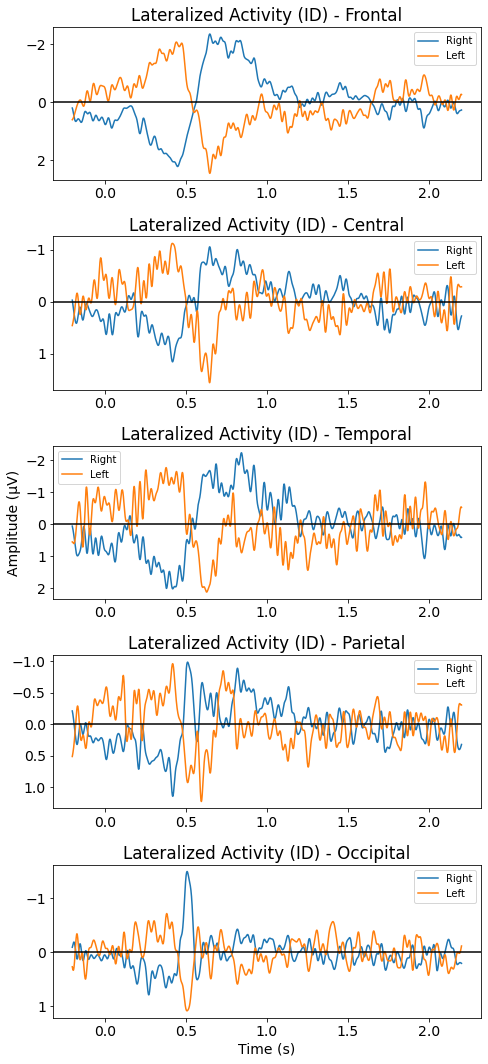

In [133]:
time_window = (times >= -0.2) & (times <= 2.2)

plt.rcParams.update({'font.size':14})
fig, axs = plt.subplots(5, 1, figsize=(7, 15))

for i, cur_cluster in enumerate(clusters_chs.keys()): 
    cda_stacked = []
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['left'])
    CDA_all_stacked_left = np.stack(cda_stacked)
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['right'])
    CDA_all_stacked_right = np.stack(cda_stacked)

    #CDA_all_stacked = np.stack(CDA_all)
    CDA_all_mean_right = np.mean(CDA_all_stacked_right, 0)
    CDA_all_mean_left = np.mean(CDA_all_stacked_left, 0)

    axs[i].plot(times[time_window], CDA_all_mean_right[time_window] * 1e6, label='Right')
    axs[i].plot(times[time_window], CDA_all_mean_left[time_window] * -1e6, label='Left')
    #plt.axvline(x=11, color ='k', linestyle='--')
    axs[i].axhline(y=0, color ='k', linestyle='-')
    axs[i].invert_yaxis()
    plt.rcParams.update({'font.size':10})
    axs[i].legend()
    plt.rcParams.update({'font.size':14})
    axs[i].set_title(f'Lateralized Activity (ID) - {cur_cluster}')

axs[2].set_ylabel('Amplitude (μV)')
axs[4].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

fig.savefig('R2b Time - Lateralized ID.png', dpi=300, format='png')

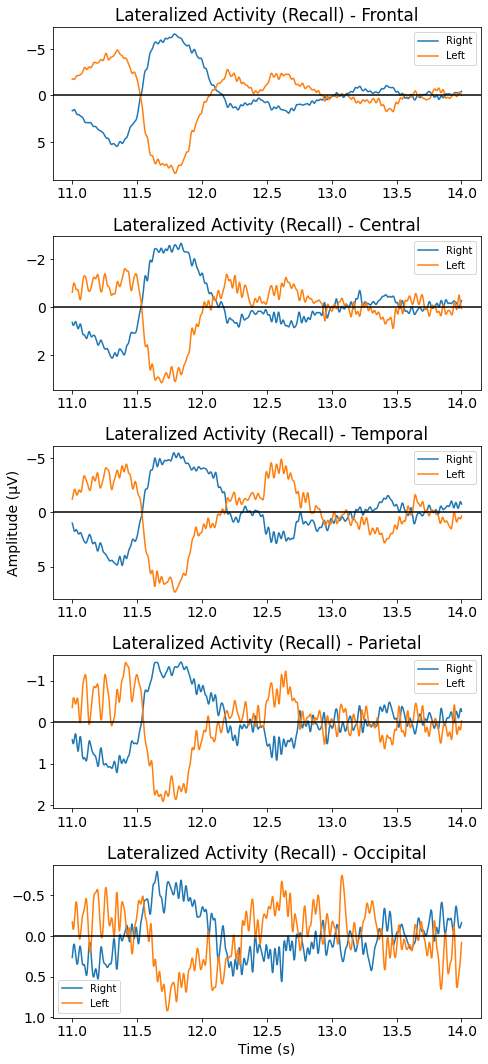

In [134]:
time_window = (times >= 11) & (times <= 14)

plt.rcParams.update({'font.size':14})
fig, axs = plt.subplots(5, 1, figsize=(7, 15))

for i, cur_cluster in enumerate(clusters_chs.keys()): 
    cda_stacked = []
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['left'])
    CDA_all_stacked_left = np.stack(cda_stacked)
    for participant in CDA_lat_all.keys():
        cda_stacked.append(CDA_lat_all[participant][cur_cluster]['right'])
    CDA_all_stacked_right = np.stack(cda_stacked)

    #CDA_all_stacked = np.stack(CDA_all)
    CDA_all_mean_right = np.mean(CDA_all_stacked_right, 0)
    CDA_all_mean_left = np.mean(CDA_all_stacked_left, 0)

    axs[i].plot(times[time_window], CDA_all_mean_right[time_window] * 1e6, label='Right')
    axs[i].plot(times[time_window], CDA_all_mean_left[time_window] * -1e6, label='Left')
    #plt.axvline(x=11, color ='k', linestyle='--')
    axs[i].axhline(y=0, color ='k', linestyle='-')
    axs[i].invert_yaxis()
    plt.rcParams.update({'font.size':10})
    axs[i].legend()
    plt.rcParams.update({'font.size':14})
    axs[i].set_title(f'Lateralized Activity (Recall) - {cur_cluster}')

axs[2].set_ylabel('Amplitude (μV)')
axs[4].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

fig.savefig('R2c Time - Lateralized Recall.png', dpi=300, format='png')

## R3 - CDA: ID & Recall (SS=All, Perf=Good)
Figure X in the paper.

In [47]:
total_subjects = 0
total_trials = 0

CDA_ss_all = dict()
#==================================================================
# Main Loop - Loading All Files & Saving Clean Epochs.
#==================================================================
pbar = tqdm(total=20)
for filepath in glob.iglob(directory_data + '*.bdf'):
    filename = filepath[filepath.rfind('\\')+1:]
    
    # Skipping Exceptions with multiple EEG files. (they will be loaded with Block 1 (B1))
    if filename in ['M8M1_B3.bdf','M8M1_B4.bdf','M8M2_B3.bdf','M8M2_B4.bdf','T9F2_B3-B4.bdf','T9M1_B3-B4.bdf']:
        continue
    
    tic = time.time()
    print('Processing: ' + filename + '...')

    # 1. -- Load File --
    if filename not in ['M8M1_B1-B2.bdf', 'M8M2_B1-B2.bdf', 'T9F2_B1-B2.bdf', 'T9M1_B1-B2.bdf']: # Check for exceptions with multiple EEG files.
        raw = read_raw_bdf(filepath, preload=True)
    else:
        if filename == 'M8M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M1_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M1_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M1.bdf'
        if filename == 'M8M2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M2_B3.bdf', preload=True)
            raw3 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'M8M2_B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2, raw3])
            filename = 'M8M2.bdf'
        if filename == 'T9F2_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'T9F2_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9F2.bdf'
        if filename == 'T9M1_B1-B2.bdf':
            raw1 = read_raw_bdf(filepath, preload=True)
            raw2 = read_raw_bdf(filepath[:filepath.rfind('\\')+1] + 'T9M1_B3-B4.bdf', preload=True)
            raw = concatenate_raws([raw1, raw2])
            filename = 'T9M1.bdf'    

    raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
    raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
    raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})
    
    # TODO: DOUBLE CHECK THE EXG4, EXG5 QUALITY ON ALL PARTICIPANTS.

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # TODO: Manual Intervention or not?
    # Bad channels - manual removal...
    # Subject T23F1.bdf: PO4
    # Subject T18F2.bdf: Iz
    #raw = raw.drop_channels('PO4')
    #raw = raw.drop_channels('Iz')

    # Sampling Frequency
    sfreq = raw.info['sfreq']

    # Events 
    events = find_events(raw)

    # Load Behav Data.
    df_behav = pd.read_csv(directory_data + filename[:filename.rfind('.')] + '.csv', sep=',')

    # Rework Events based on Behav Data. (to add Side and SetSize information)
    new_events = []
    nb_trials = 0
    total_skipped = 0
    for e in events:
        cur_cond = None
        cur_side = None
        cur_perf = None
        if e[2] == 2: # Find Start of Trial
            cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
            cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
            cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
            if cur_cond is not None and cur_side is not None and cur_perf is not None:
                #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
                temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
                new_events.append(temp_event) # Make a new list of events with new custom triggers.
            else:
                total_skipped = total_skipped + 1
                print('Skipping this event {}: No Cond or Side or Perf'.format(e))

            nb_trials = nb_trials + 1

            # Check Synch!
            #if (nb_trials + 1) % 10 == 0:
                #print('Check Synch!')

    # Working with modified events from now on.
    events = new_events
    
    total_trials = total_trials + nb_trials
    print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

    # Remove Events ID if not in file (e.g. some participants don't have bad trials with ss=1).
    print('==================================================')
    print('Removing Events ID not in EEG File...')
    cur_event_id = copy.deepcopy(event_id)
    newevents_in_file = set(np.array(events)[:,2])
    keys_to_delete = []
    for e in cur_event_id.keys():
        if event_id[e] not in newevents_in_file:
            print('Event: {} ({}), not present.'.format(e, event_id[e]))
            keys_to_delete.append(e)
    for key in keys_to_delete:
        del cur_event_id[key]
    print('==================================================') 
    
    # Calculate average response time.
    resp_time_in_ticks = []
    for i, e in enumerate(events):
        if e[2] == 8:
            if events[i+1,2] == 32:
                resp_time_in_ticks.append(events[i+1,0] - events[i,0])
            elif events[i+1,2] == 16: #Synch?!
                if events[i+2,2] == 32:
                    resp_time_in_ticks.append(events[i+2,0] - events[i,0])
                else:
                    print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))
            else:
                print('[Error] No Response?! Trigger: {}'.format(events[i+1,2]))

    mean_rt = np.mean(resp_time_in_ticks)
    median_rt = np.median(resp_time_in_ticks)
    std_rt = np.std(resp_time_in_ticks)
    print('Response Time ~{:.2f}s (std:{:.2f})'.format(mean_rt/sfreq, std_rt/sfreq))
        
    # Epoching
    # TODO: take values from const.
    epochs = Epochs(raw, events, event_id=cur_event_id, tmin=-2, tmax=15, baseline=(-1, -0.2), preload=True, event_repeated='merge', on_missing='warn')
    
    epochs = epochs.filter(1, 30)
    #epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))
    
    # Cleaning
    #ar = AutoReject(n_jobs=10)
    #epochs, reject_log = ar.fit_transform(epochs, return_log=True) 
    #fig, ax = plt.subplots(figsize=(15,8))
    #reject_log.plot('horizontal', ax=ax)
    
    # Save Clean Epochs for each Participant.
    #data_pickle = dict()
    #data_pickle['events'] = events
    #data_pickle['epochs'] = epochs
    #with open(directory_preproc + f"cleanAR/Subject_{filename[:-4]}_cleanAR.pkl","wb") as f:
    #    pickle.dump(data_pickle, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    CDA_ss_all[filename] = dict()
    for cluster in clusters_chs.keys():
        CDA_ss_all[filename][cluster] = dict()
        
        # Get Left and Right Channel in the cluster.
        clusters_chs_right = []
        clusters_chs_left = []
        for ch in clusters_chs[cluster]:
            if ch[-1] != 'z':
                if int(ch[-1]) % 2 == 0:
                    clusters_chs_right.append(ch)
                else:
                    clusters_chs_left.append(ch)
            
        for size in conds:
            CDA_ss_all[filename][cluster][size] = dict()
            for side in ['left', 'right']:
                e_filter = size + '/' + side + '/' + 'good'
                try:
                    cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
                    cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()
                    if side == 'right':
                        cur_cda = (np.mean(cur_evoked_2.get_data(), 0) - np.mean(cur_evoked_1.get_data(), 0))
                    else:
                        cur_cda = (np.mean(cur_evoked_1.get_data(), 0) - np.mean(cur_evoked_2.get_data(), 0))

                    CDA_ss_all[filename][cluster][size][side] = cur_cda

                    times = cur_evoked_1.times
                    
                    #if size == '3':
                    #    plt.figure()
                    #    plt.plot(times, cur_cda, label=f'CDA {size}-{side}')
                    #    plt.show()

                except:
                    print(f'Skipping... {filename} - {size} - {side}')
    
    total_subjects = total_subjects + 1
    
    toc = time.time()
    print('Subject {} Done! ({:.2f}s)'.format(filename[:-4], toc-tic))
    
    pbar.update(1)
    
pbar.close() 
print(f'{total_subjects} Participants with a total of {total_trials}.')

data_pickle = dict()
data_pickle['CDA_ss_all'] = CDA_ss_all
data_pickle['times'] = times
with open(directory_preproc + 'CDA/CDA_data_raw.pkl',"wb") as f:
    pickle.dump(data_pickle, f)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Processing: F12F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



  5%|████▏                                                                              | 1/20 [00:39<12:27, 39.32s/it]

Subject F12F2 Done! (39.32s)
Processing: F12M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F12M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5881855  =      0.000 ...  2872.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 10%|████████▎                                                                          | 2/20 [01:19<11:55, 39.77s/it]

Subject F12M1 Done! (40.08s)
Processing: F19M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F19M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7309311  =      0.000 ...  3569.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 15%|████████████▍                                                                      | 3/20 [02:04<11:56, 42.17s/it]

Subject F19M1 Done! (45.04s)
Processing: F26F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F26F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3024895  =      0.000 ...  1477.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
237 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 42 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Event: 3/right/good (311), not present.
Response Time ~nans (std:nan)
Not setting metadata
42 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 eve

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Skipping... F26F2.bdf - 3 - right
Skipping... F26F2.bdf - 3 - right
Skipping... F26F2.bdf - 3 - right
Skipping... F26F2.bdf - 3 - right


 20%|████████████████▌                                                                  | 4/20 [02:24<08:55, 33.50s/it]

Skipping... F26F2.bdf - 3 - right
Subject F26F2 Done! (20.20s)
Processing: F5M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\F5M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3280895  =      0.000 ...  1602.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
258 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 42 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/left/bad (222), not present.
Event: 2/classicmod/bad (232), not present.
Event: 3/right/bad (312), not present.
Event: 3/left/good (321), not present.
Response Time ~nans (std:nan)
Not setting metadata
42 matching events fou

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Skipping... F5M1.bdf - 3 - left
Skipping... F5M1.bdf - 3 - left
Skipping... F5M1.bdf - 3 - left
Skipping... F5M1.bdf - 3 - left


 25%|████████████████████▊                                                              | 5/20 [02:44<07:08, 28.59s/it]

Skipping... F5M1.bdf - 3 - left
Subject F5M1 Done! (19.89s)
Processing: M22F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M22F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6383615  =      0.000 ...  3117.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 30%|████████████████████████▉                                                          | 6/20 [03:24<07:35, 32.55s/it]

Subject M22F2 Done! (40.23s)
Processing: M8M1_B1-B2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M1_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4220927  =      0.000 ...  2061.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M1_B3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3491839  =      0.000 ...  1705.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M1_B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1535999  =      0.000 ...   750.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
645 events found
Event IDs: [    1     2     4 

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 35%|█████████████████████████████                                                      | 7/20 [04:19<08:37, 39.83s/it]

Subject M8M1 Done! (54.82s)
Processing: M8M2_B1-B2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M2_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3672063  =      0.000 ...  1793.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M2_B3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1574911  =      0.000 ...   769.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\M8M2_B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1384447  =      0.000 ...   676.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
518 events found
Event IDs: [    1     2     4  

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 40%|█████████████████████████████████▏                                                 | 8/20 [05:02<08:09, 40.79s/it]

Subject M8M2 Done! (42.84s)
Processing: S20M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\S20M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948863  =      0.000 ...  3393.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 2/classicmod/bad (232), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 45%|█████████████████████████████████████▎                                             | 9/20 [05:44<07:33, 41.21s/it]

Subject S20M1 Done! (42.14s)
Processing: S21F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\S21F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7776255  =      0.000 ...  3797.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
576 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 94 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Response Time ~nans (std:nan)
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 94 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 50%|█████████████████████████████████████████                                         | 10/20 [06:30<07:08, 42.81s/it]

Subject S21F1 Done! (46.38s)
Processing: T11F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T11F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5885951  =      0.000 ...  2874.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 55%|█████████████████████████████████████████████                                     | 11/20 [07:08<06:09, 41.09s/it]

Subject T11F1 Done! (37.21s)
Processing: T16F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T16F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5064703  =      0.000 ...  2473.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
459 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 75 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Response Time ~nans (std:nan)
Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 75 events and 34817 original time points

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 60%|█████████████████████████████████████████████████▏                                | 12/20 [07:43<05:14, 39.36s/it]

Subject T16F2 Done! (35.40s)
Processing: T18F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T18F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6344703  =      0.000 ...  3098.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/classicmod/bad (232), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 8

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 65%|█████████████████████████████████████████████████████▎                            | 13/20 [08:25<04:40, 40.13s/it]

Subject T18F2 Done! (41.89s)
Processing: T18M1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T18M1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6027263  =      0.000 ...  2943.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Event: 2/right/bad (212), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 eve

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [09:07<04:05, 40.85s/it]

Subject T18M1 Done! (42.51s)
Processing: T23F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T23F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6590463  =      0.000 ...  3218.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/left/bad (122), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [09:48<03:23, 40.76s/it]

Subject T23F1 Done! (40.54s)
Processing: T23F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T23F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6369279  =      0.000 ...  3110.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [10:29<02:43, 40.89s/it]

Subject T23F2 Done! (41.22s)
Processing: T25F1.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T25F1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7065599  =      0.000 ...  3450.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [11:10<02:02, 40.80s/it]

Subject T25F1 Done! (40.59s)
Processing: T9F2_B1-B2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T9F2_B1-B2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3352575  =      0.000 ...  1637.000 secs...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\T9F2_B3-B4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3555327  =      0.000 ...  1736.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
517 events found
Event IDs: [    1     2     4     8    16    32 65536]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 2/classicmod/bad (232), not present.
Response Time

C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [11:56<01:25, 42.52s/it]

Subject T9F2 Done! (46.52s)
Processing: W10F2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\W10F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6434815  =      0.000 ...  3142.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
A total of 84 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/right/bad (112), not present.
Event: 1/left/bad (122), not present.
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [12:38<00:42, 42.15s/it]

Subject W10F2 Done! (41.28s)
Processing: W17M2.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\Data\W17M2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7319551  =      0.000 ...  3574.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
513 events found
Event IDs: [    1     2     4     8    16    32 65540]
A total of 83 trials were added and 0 were skipped.
Removing Events ID not in EEG File...
Event: 1/classicmod/bad (132), not present.
Response Time ~nans (std:nan)
Not setting metadata
83 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 83 events and 34817 original time points ...


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [13:24<00:00, 40.22s/it]

Subject W17M2 Done! (46.24s)
20 Participants with a total of 1617.


Skipping...F26F2.bdf-3-right
Skipping...F5M1.bdf-3-left


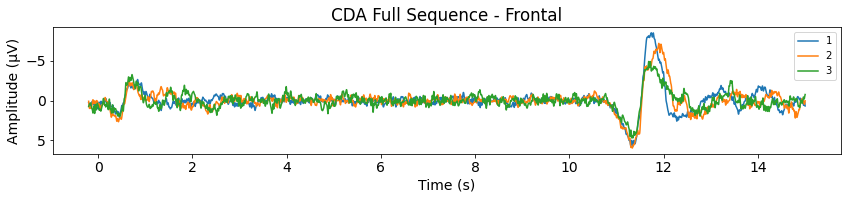

In [135]:
times_window = (times >= -0.2) & (times <= 15)

plt.rcParams.update({'font.size':14})
fig = plt.figure(figsize=(12, 3))

for size in conds:
    cda = []
    for participant in CDA_ss_all.keys():
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['left'])
        except:
            print(f'Skipping...{participant}-{size}-left')
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['right'])
        except:
            print(f'Skipping...{participant}-{size}-right')

    cda = np.stack(cda)
    cda_mean = np.mean(cda, 0)

    plt.plot(times[times_window], cda_mean[times_window] * 1e6, label=size)

plt.rcParams.update({'font.size':10})
plt.legend()
plt.rcParams.update({'font.size':14})
plt.title(f'CDA Full Sequence - Frontal')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Time (s)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

fig.savefig('R3a Time - CDA Full Sequence.png', dpi=300, format='png')

Skipping...F26F2.bdf-Frontal-3-right
Skipping...F5M1.bdf-Frontal-3-left
Skipping...F26F2.bdf-Central-3-right
Skipping...F5M1.bdf-Central-3-left
Skipping...F26F2.bdf-Temporal-3-right
Skipping...F5M1.bdf-Temporal-3-left
Skipping...F26F2.bdf-Parietal-3-right
Skipping...F5M1.bdf-Parietal-3-left
Skipping...F26F2.bdf-Occipital-3-right
Skipping...F5M1.bdf-Occipital-3-left


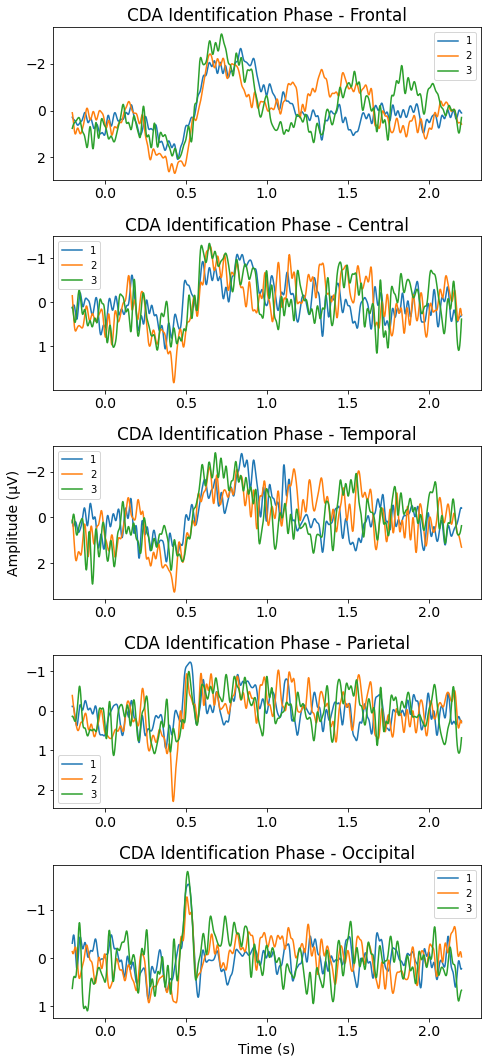

In [116]:
times_window = (times >= -0.2) & (times <= 2.2)

plt.rcParams.update({'font.size':14})
fig, axs = plt.subplots(5, 1, figsize=(7, 15))

for i, cluster in enumerate(clusters_chs.keys()):
    for size in conds:
        cda = []
        for participant in CDA_ss_all.keys():
            try:
                cda.append(CDA_ss_all[participant][cluster][size]['left'])
            except:
                print(f'Skipping...{participant}-{cluster}-{size}-left')
            try:
                cda.append(CDA_ss_all[participant][cluster][size]['right'])
            except:
                print(f'Skipping...{participant}-{cluster}-{size}-right')

        cda = np.stack(cda)
        cda_mean = np.mean(cda, 0)

        axs[i].plot(times[times_window], cda_mean[times_window] * 1e6, label=size)
        axs[i].invert_yaxis()
        plt.rcParams.update({'font.size':10})
        axs[i].legend()
        plt.rcParams.update({'font.size':14})
        axs[i].set_title(f'CDA Identification Phase - {cluster}')

axs[2].set_ylabel('Amplitude (μV)')
axs[4].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

fig.savefig('R3b Time - CDA ID.png', dpi=300, format='png')

Skipping...F26F2.bdf-Frontal-3-right
Skipping...F5M1.bdf-Frontal-3-left
Skipping...F26F2.bdf-Central-3-right
Skipping...F5M1.bdf-Central-3-left
Skipping...F26F2.bdf-Temporal-3-right
Skipping...F5M1.bdf-Temporal-3-left
Skipping...F26F2.bdf-Parietal-3-right
Skipping...F5M1.bdf-Parietal-3-left
Skipping...F26F2.bdf-Occipital-3-right
Skipping...F5M1.bdf-Occipital-3-left


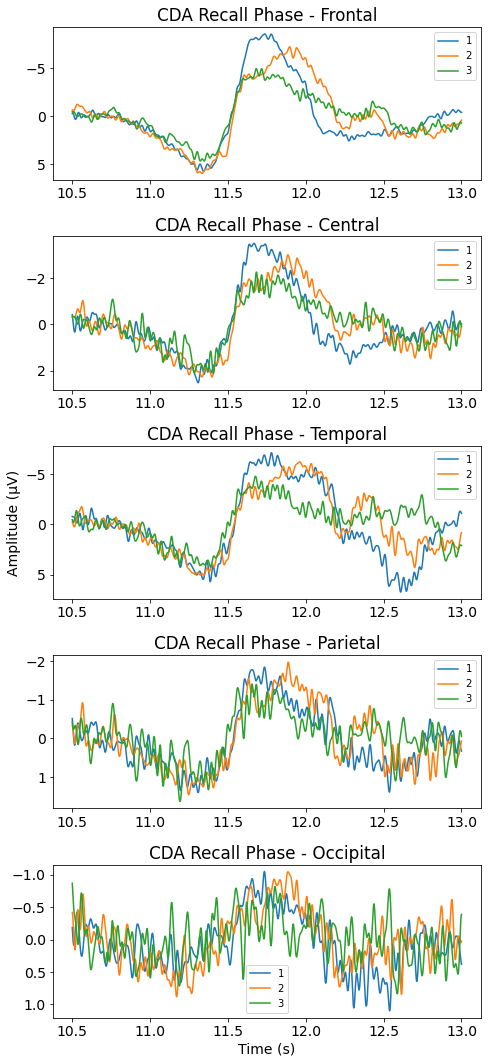

In [117]:
times_window = (times >= 10.5) & (times <= 13)

plt.rcParams.update({'font.size':14})
fig, axs = plt.subplots(5, 1, figsize=(7, 15))

for i, cluster in enumerate(clusters_chs.keys()):
    for size in conds:
        cda = []
        for participant in CDA_ss_all.keys():
            try:
                cda.append(CDA_ss_all[participant][cluster][size]['left'])
            except:
                print(f'Skipping...{participant}-{cluster}-{size}-left')
            try:
                cda.append(CDA_ss_all[participant][cluster][size]['right'])
            except:
                print(f'Skipping...{participant}-{cluster}-{size}-right')

        cda = np.stack(cda)
        cda_mean = np.mean(cda, 0)

        axs[i].plot(times[times_window], cda_mean[times_window] * 1e6, label=size)
        axs[i].invert_yaxis()
        plt.rcParams.update({'font.size':10})
        axs[i].legend()
        plt.rcParams.update({'font.size':14})
        axs[i].set_title(f'CDA Recall Phase - {cluster}')

axs[2].set_ylabel('Amplitude (μV)')
axs[4].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

fig.savefig('R3c Time - CDA Recall.png', dpi=300, format='png')

# Extra - Move / Delete me...

### All Channels...

0it [00:00, ?it/s]

Loading: Subject_F12F2_cleanAR.pkl...
61 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


1it [01:36, 96.21s/it]

Subject Subject_F12F2_cleanAR Done! (96.21s)
Loading: Subject_F12M1_cleanAR.pkl...
77 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


2it [03:48, 117.40s/it]

Subject Subject_F12M1_cleanAR Done! (132.22s)
Loading: Subject_F19M1_cleanAR.pkl...
55 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


3it [05:40, 115.14s/it]

Subject Subject_F19M1_cleanAR Done! (112.45s)
Loading: Subject_F26F2_cleanAR.pkl...
39 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


4it [06:44, 94.96s/it] 

Subject Subject_F26F2_cleanAR Done! (64.03s)
Loading: Subject_F5M1_cleanAR.pkl...
24 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


5it [07:25, 75.31s/it]

Subject Subject_F5M1_cleanAR Done! (40.45s)
Loading: Subject_M22F2_cleanAR.pkl...
65 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


6it [09:24, 90.18s/it]

Subject Subject_M22F2_cleanAR Done! (119.06s)
Loading: Subject_M8M1_cleanAR.pkl...
83 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


7it [11:32, 102.63s/it]

Subject Subject_M8M1_cleanAR Done! (128.25s)
Loading: Subject_M8M2_cleanAR.pkl...
82 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


8it [13:49, 113.54s/it]

Subject Subject_M8M2_cleanAR Done! (136.92s)
Loading: Subject_S20M1_cleanAR.pkl...
78 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


9it [16:11, 122.46s/it]

Subject Subject_S20M1_cleanAR Done! (142.06s)
Loading: Subject_S21F1_cleanAR.pkl...
94 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


10it [18:51, 133.85s/it]

Subject Subject_S21F1_cleanAR Done! (159.36s)
Loading: Subject_T11F1_cleanAR.pkl...
68 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


11it [20:37, 125.44s/it]

Subject Subject_T11F1_cleanAR Done! (106.38s)
Loading: Subject_T16F2_cleanAR.pkl...
75 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


12it [23:10, 133.79s/it]

Subject Subject_T16F2_cleanAR Done! (152.87s)
Loading: Subject_T18F2_cleanAR.pkl...
27 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


13it [24:10, 111.62s/it]

Subject Subject_T18F2_cleanAR Done! (60.61s)
Loading: Subject_T18M1_cleanAR.pkl...
74 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


14it [26:54, 127.29s/it]

Subject Subject_T18M1_cleanAR Done! (163.50s)
Loading: Subject_T23F1_cleanAR.pkl...
79 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


15it [29:04, 128.17s/it]

Subject Subject_T23F1_cleanAR Done! (130.22s)
Loading: Subject_T23F2_cleanAR.pkl...
81 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


16it [31:32, 134.12s/it]

Subject Subject_T23F2_cleanAR Done! (147.92s)
Loading: Subject_T25F1_cleanAR.pkl...
84 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


17it [33:44, 133.33s/it]

Subject Subject_T25F1_cleanAR Done! (131.49s)
Loading: Subject_T9F2_cleanAR.pkl...
50 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


18it [35:31, 125.54s/it]

Subject Subject_T9F2_cleanAR Done! (107.40s)
Loading: Subject_W10F2_cleanAR.pkl...
70 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


19it [37:43, 127.48s/it]

Subject Subject_W10F2_cleanAR Done! (132.01s)
Loading: Subject_W17M2_cleanAR.pkl...
83 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


20it [39:57, 119.88s/it]

Subject Subject_W17M2_cleanAR Done! (134.25s)


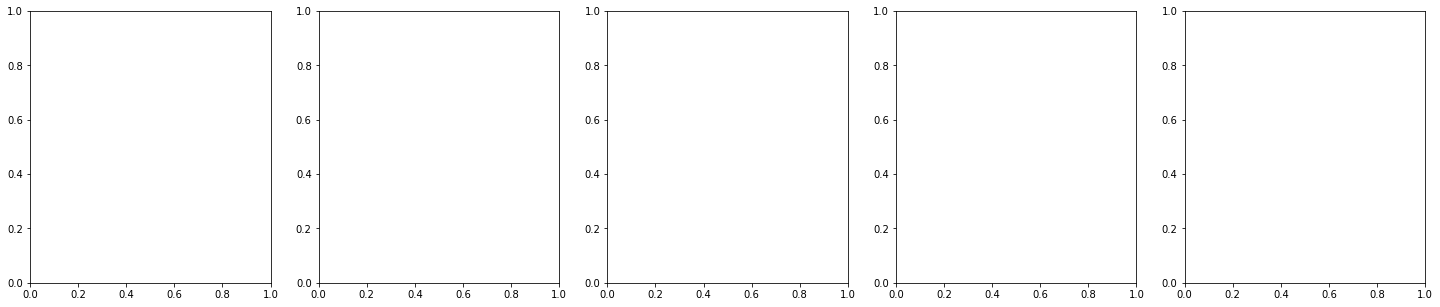

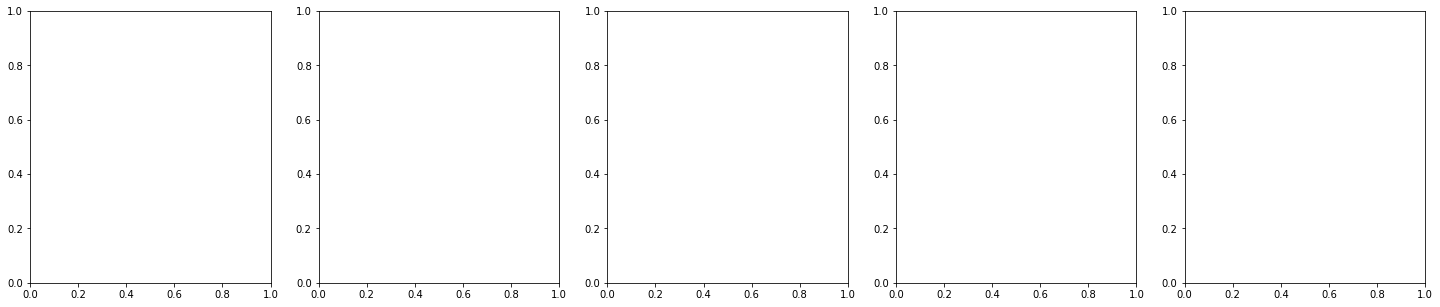

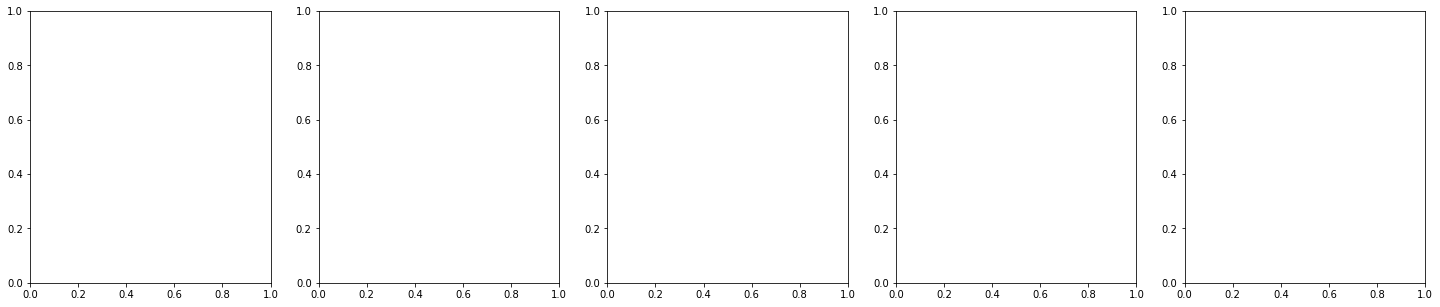

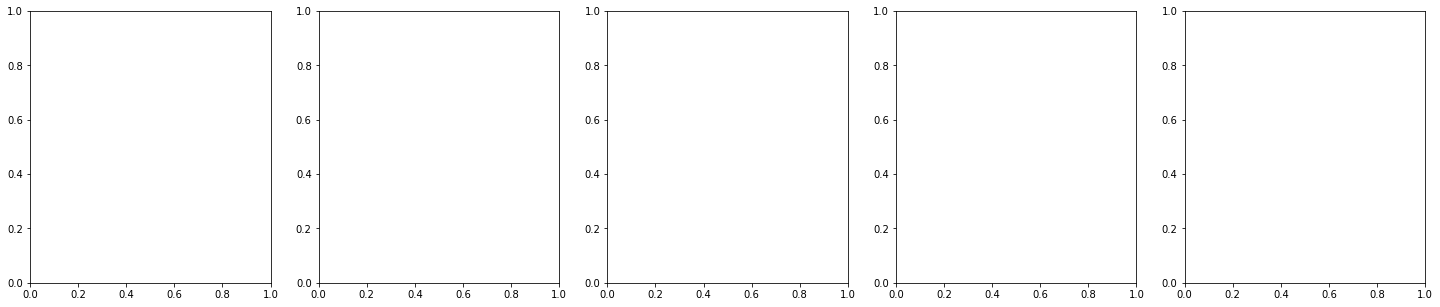

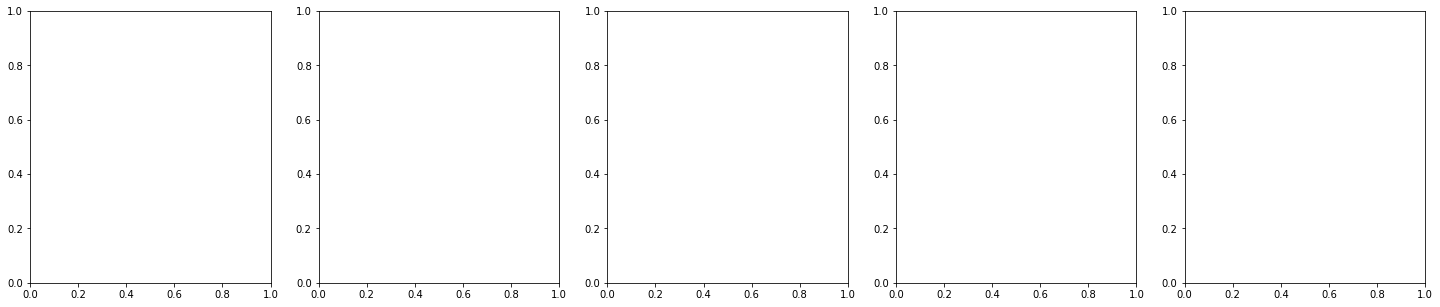

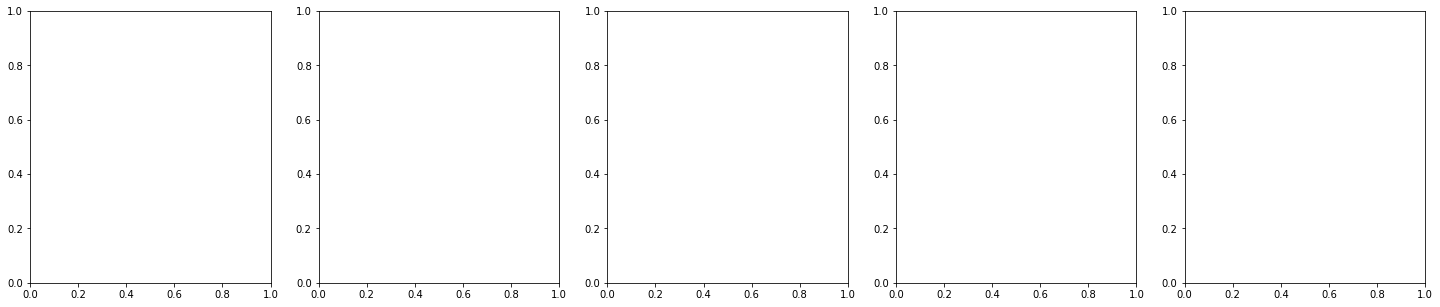

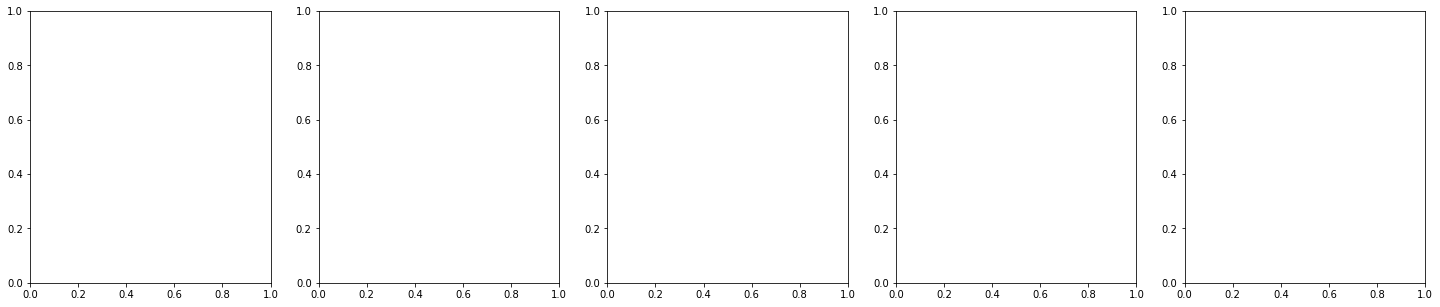

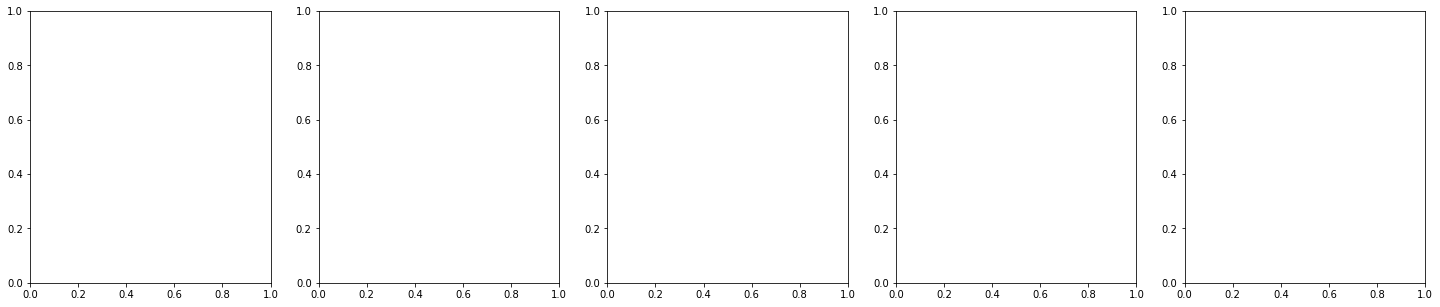

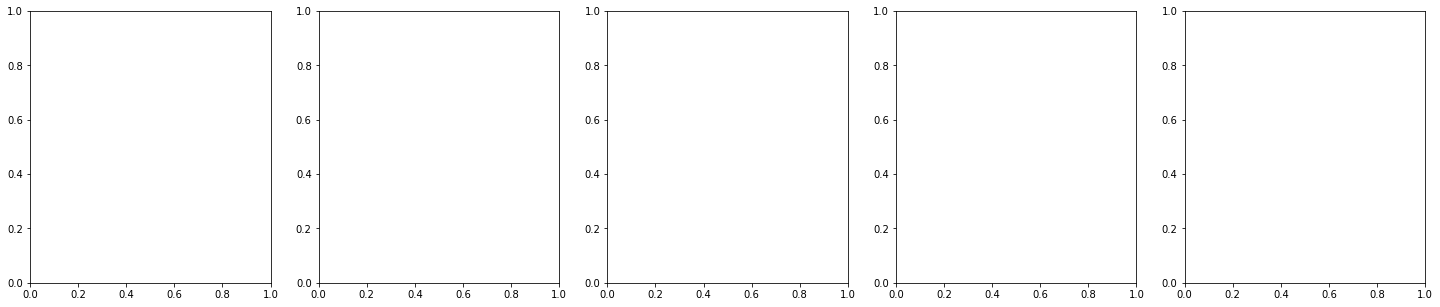

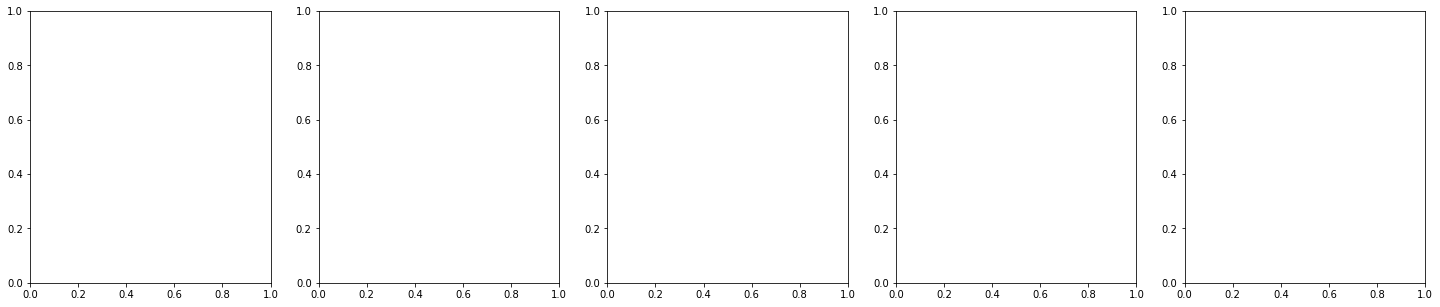

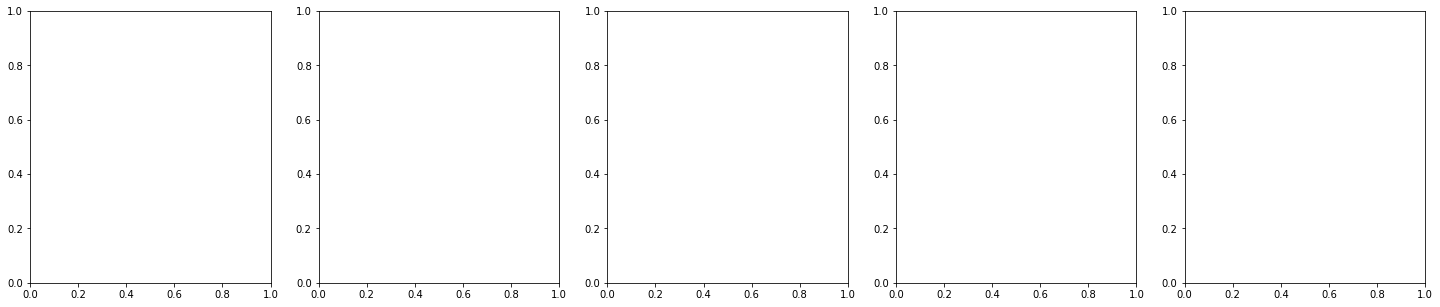

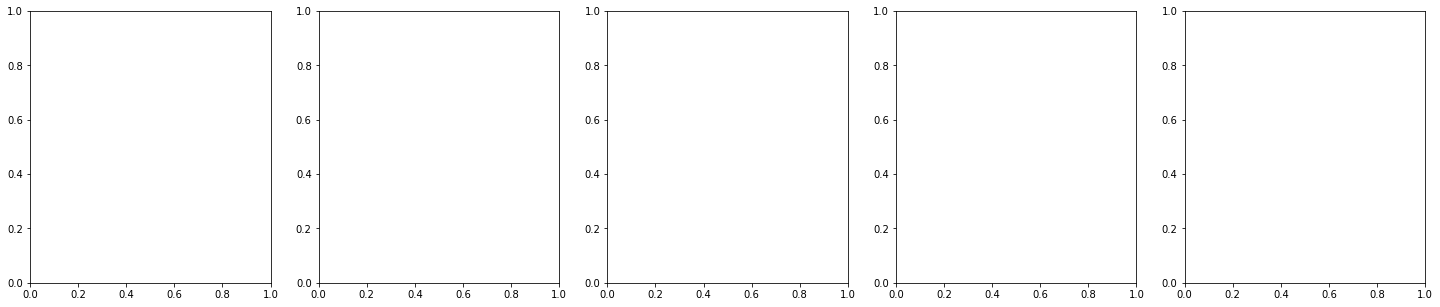

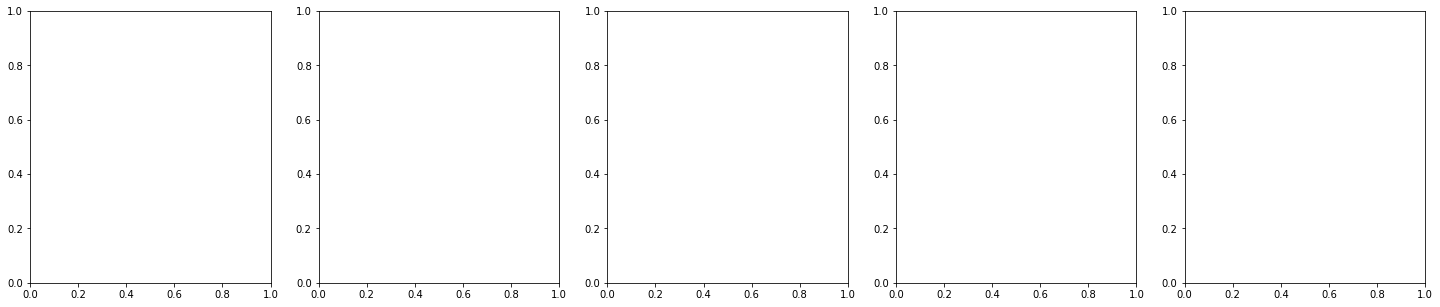

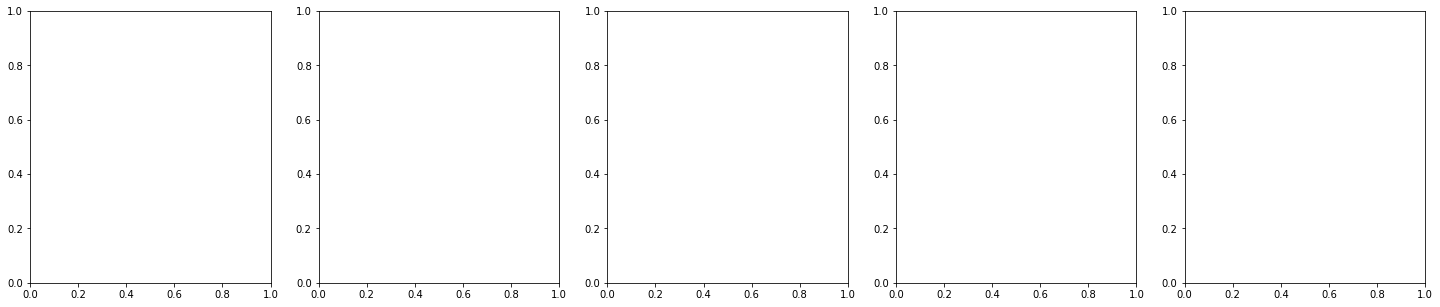

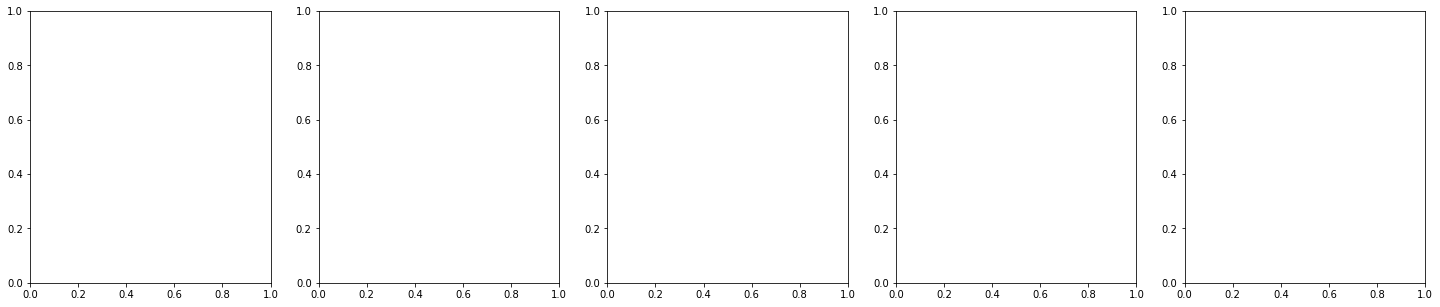

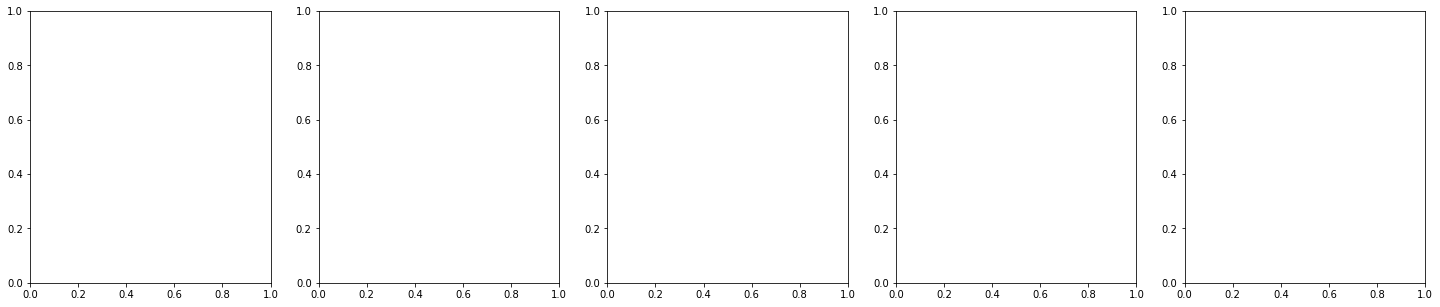

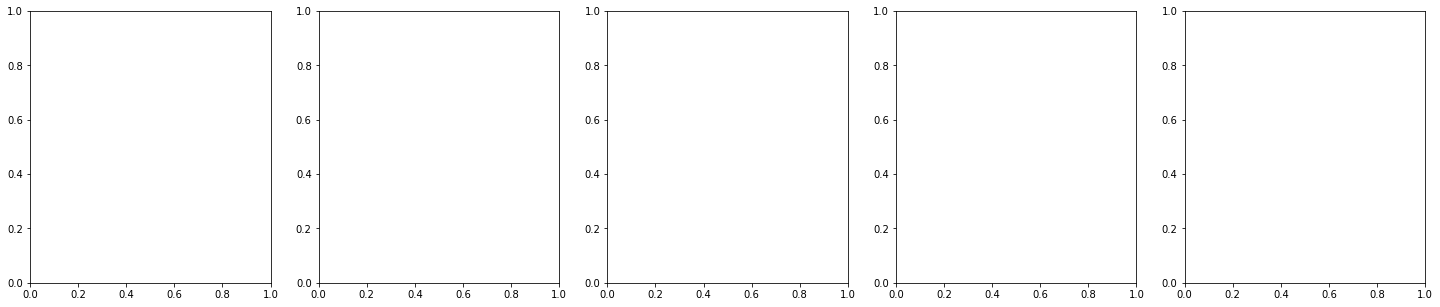

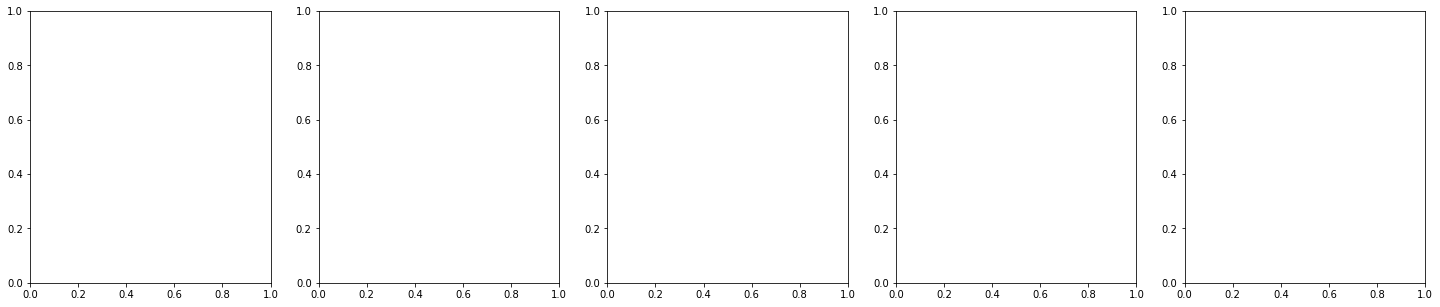

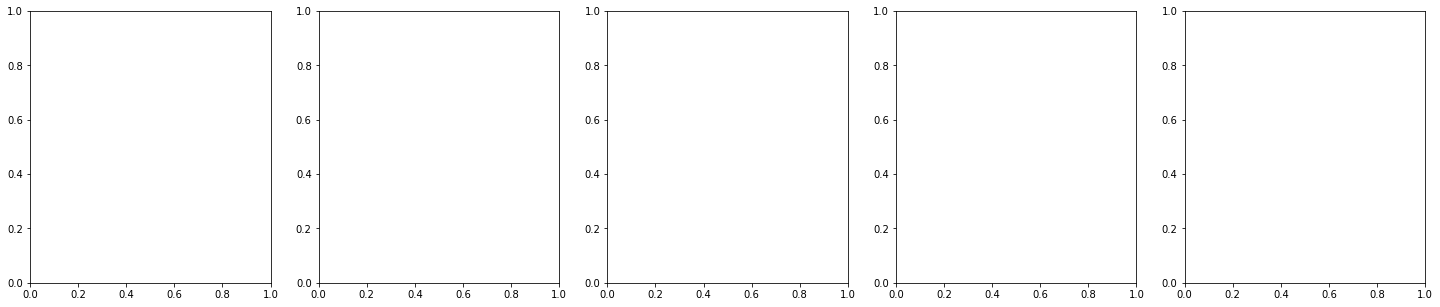

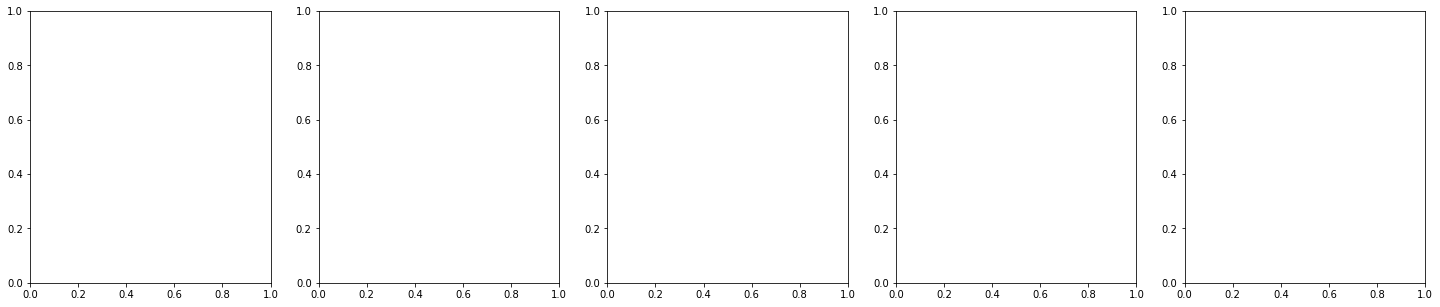

In [4]:
signal_all = dict()

#=============================================================================
# Main Loop - Loading Files 1 by 1 to get CDA per Cluster per Subject.
#=============================================================================
for filepath in tqdm(glob.iglob(directory_preproc + 'cleanAR\\Subject_*_cleanAR.pkl')):
    filename = filepath[filepath.rfind('\\')+1:]
    signal_all[filename] = dict()
    
    tic = time.time()
    print(f'Loading: {filename}...')

    with open(filepath, "rb") as f:
        data_pickle = pickle.load(f)

    epochs = data_pickle['epochs']
    print('{} epochs loaded.'.format(len(epochs)))
    
    epochs = epochs.filter(1, 50)
    epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))

    perf = 'good'
    sides = ['right', 'left', 'classicmod']
    
    for cur_ch in channels:
        signal_all[filename][cur_ch] = dict()

        for side in sides:
            e_filter = side + '/' + perf if (perf == 'good' or perf == 'bad') else side
            cur_evoked = epochs[e_filter].copy().pick_channels([cur_ch]).crop(tmin=-0.5, tmax=15).average()
            signal_all[filename][cur_ch][side] = cur_evoked.get_data()

            times = cur_evoked.times
        
    #with open(directory_preproc + 'ERSP_1-50Hz/' + filename.replace("cleanAR","ersp2"),"wb") as f:
    #    pickle.dump(power, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Try to clear memory. It shouldn't change anything as I am re-allocating that space, but can't be bad...
    del data_pickle
    del epochs
    
    toc = time.time()
    print('Subject {} Done! ({:.2f}s)'.format(filename[:-4], toc-tic))
    
for ch in channels: 
    signal_stacked = []
    for participant in signal_all.keys():
        signal_stacked.append(signal_all[participant][ch]['classicmod'])
        signal_stacked.append(signal_all[participant][ch]['right'])
        signal_stacked.append(signal_all[participant][ch]['left'])
    signal_stacked = np.stack(signal_stacked).squeeze()
    #for participant in CDA_all.keys():
    #    cda_stacked.append(CDA_all[participant][cur_cluster]['right'])
    #CDA_all_stacked_right = np.stack(cda_stacked)

    #CDA_all_stacked = np.stack(CDA_all)
    signal_mean = np.mean(signal_stacked, 0)

    fig, axs = plt.subplots(1,3, figsize=(24, 6))
    
    time_window = (times >= -0.2) & (times <= 14)
    axs[0].plot(times[time_window], signal_mean[time_window], label='CDA')
    axs[0].axvline(x=11, color ='k', linestyle='--')
    axs[0].axhline(y=0, color ='k', linestyle='-')
    axs[0].invert_yaxis()
    axs[0].set_title(ch)
    
    time_window = (times >= -0.2) & (times <= 2)
    axs[1].plot(times[time_window], signal_mean[time_window], label='CDA')
    #axs[1].axvline(x=11, color ='k', linestyle='--')
    axs[1].axhline(y=0, color ='k', linestyle='-')
    axs[1].invert_yaxis()
    axs[1].set_title(ch)
    
    time_window = (times >= 11) & (times <= 14)
    axs[2].plot(times[time_window], signal_mean[time_window], label='CDA')
    #axs[2].axvline(x=11, color ='k', linestyle='--')
    axs[2].axhline(y=0, color ='k', linestyle='-')
    axs[2].invert_yaxis()
    axs[2].set_title(ch)    
    
    plt.show()

Loading: NT All.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\F12F2\EEG\NT All.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 47105 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- H

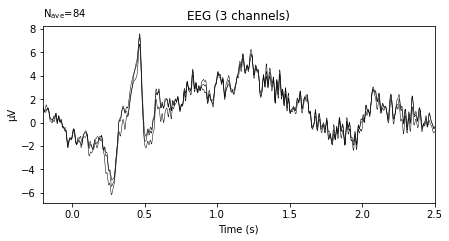

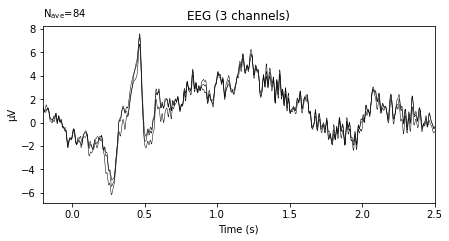

In [6]:
filepath = 'F:\\CAE - NeuroTracker\\F12F2\\EEG\\NT All.bdf'
filename = filepath[filepath.rfind('\\')+1:]
print(f'Loading: {filename}...')

raw = read_raw_bdf(filepath, preload=True)
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)
events

epochs = Epochs(raw, events, event_id=[8], tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

epochs = epochs.filter(1, 50)
epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))
    
cur_evoked = epochs.pick_channels(['O1', 'O2', 'Oz']).crop(tmin=-0.2, tmax=2.5).average()

cur_evoked.plot()

Loading: NT All.bdf...
Extracting EDF parameters from F:\CAE - NeuroTracker\F12F2\EEG\NT All.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Not setting metadata
84 matching events found
Setting baseline interval to [-3.0, 20.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 47105 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- H

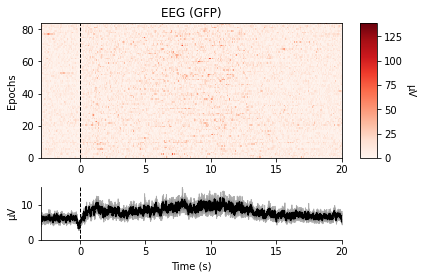

[<Figure size 432x288 with 3 Axes>]

In [114]:
filepath = 'F:\\CAE - NeuroTracker\\F12F2\\EEG\\NT All.bdf'
filename = filepath[filepath.rfind('\\')+1:]
print(f'Loading: {filename}...')

raw = read_raw_bdf(filepath, preload=True)
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Sampling Frequency
sfreq = raw.info['sfreq']

# Events 
events = find_events(raw)
events

epochs = Epochs(raw, events, event_id=[8], tmin=-3, tmax=20, baseline=(None, None), preload=True, event_repeated='merge', on_missing='warn')

epochs = epochs.filter(1, 50)
epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))
    
epochs.pick_channels(['O1', 'O2', 'Oz']).plot_image()

#cur_evoked = epochs.pick_channels(['O1', 'O2', 'Oz']).crop(tmin=-0.2, tmax=2.5).average()

#cur_evoked.plot()

In [116]:
epochs.info.ch_names

['O1', 'Oz', 'O2']

# Set Size Playground

Loading: Subject_F12F2_cleanAR.pkl...
61 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


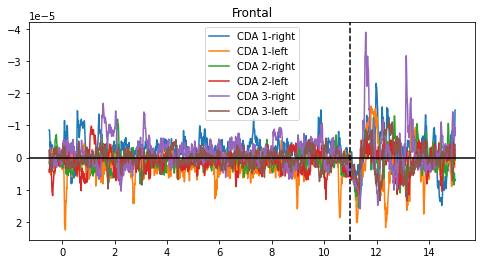

Subject Subject_F12F2_cleanAR Done! (26.24s)
Loading: Subject_F12M1_cleanAR.pkl...
77 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


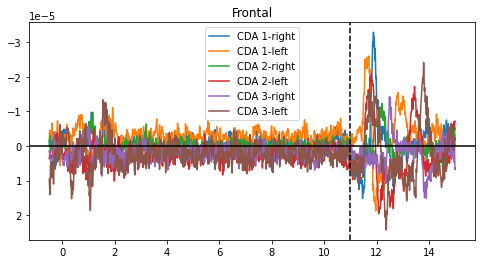

Subject Subject_F12M1_cleanAR Done! (26.22s)
Loading: Subject_F19M1_cleanAR.pkl...
55 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


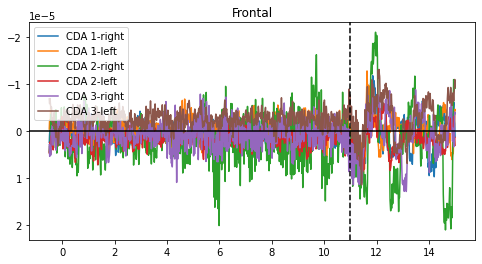

Subject Subject_F19M1_cleanAR Done! (18.84s)
Loading: Subject_F26F2_cleanAR.pkl...
39 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)
Skipping... Subject_F26F2_cleanAR.pkl - 3 - right


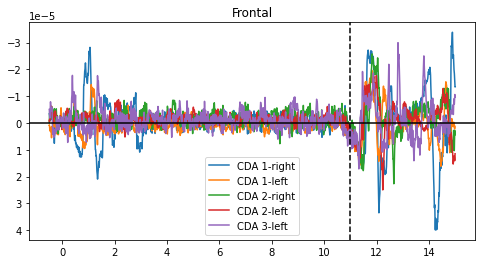

Subject Subject_F26F2_cleanAR Done! (13.31s)
Loading: Subject_F5M1_cleanAR.pkl...
24 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)
Skipping... Subject_F5M1_cleanAR.pkl - 3 - left


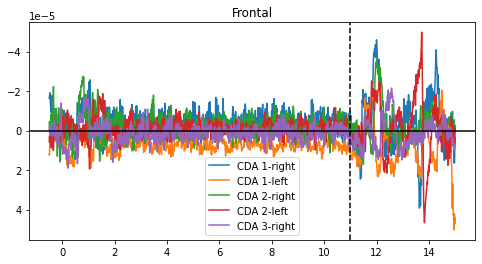

Subject Subject_F5M1_cleanAR Done! (8.77s)
Loading: Subject_M22F2_cleanAR.pkl...
65 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


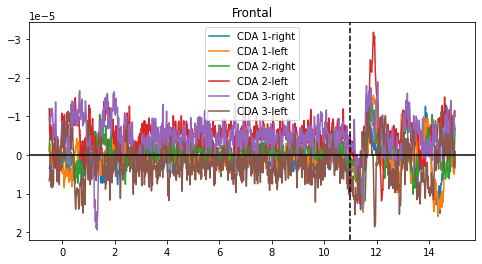

Subject Subject_M22F2_cleanAR Done! (22.31s)
Loading: Subject_M8M1_cleanAR.pkl...
83 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


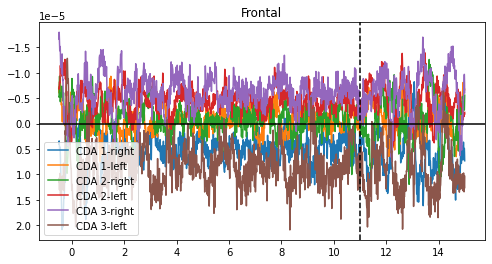

Subject Subject_M8M1_cleanAR Done! (28.02s)
Loading: Subject_M8M2_cleanAR.pkl...
82 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


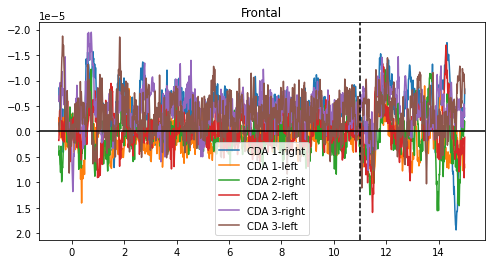

Subject Subject_M8M2_cleanAR Done! (28.44s)
Loading: Subject_S20M1_cleanAR.pkl...
78 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


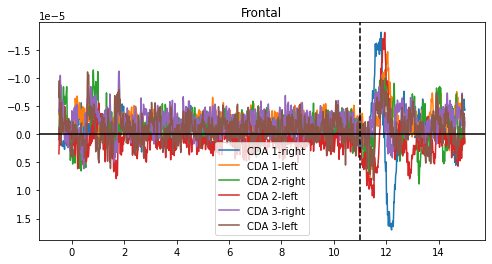

Subject Subject_S20M1_cleanAR Done! (26.47s)
Loading: Subject_S21F1_cleanAR.pkl...
94 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


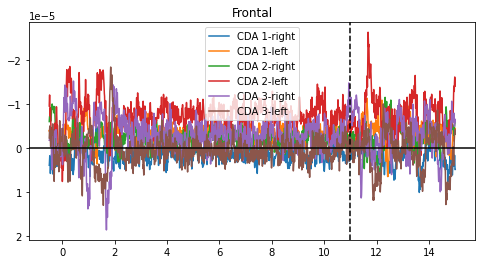

Subject Subject_S21F1_cleanAR Done! (32.12s)
Loading: Subject_T11F1_cleanAR.pkl...
68 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Yannick\Miniconda3\envs\clct\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-125-9d5371b4d280>:41: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
<ipython-input-125-9d5371b4d280>:42: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()


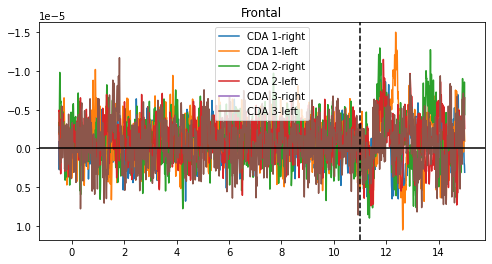

Subject Subject_T11F1_cleanAR Done! (23.17s)
Loading: Subject_T16F2_cleanAR.pkl...
75 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


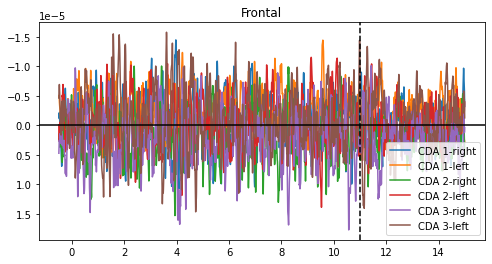

Subject Subject_T16F2_cleanAR Done! (26.31s)
Loading: Subject_T18F2_cleanAR.pkl...
27 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


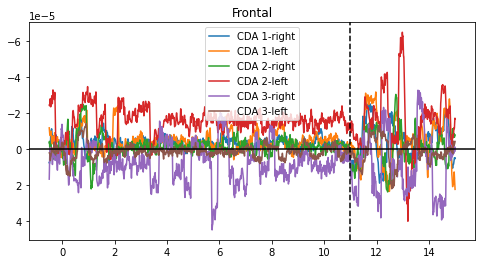

Subject Subject_T18F2_cleanAR Done! (10.87s)
Loading: Subject_T18M1_cleanAR.pkl...
74 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


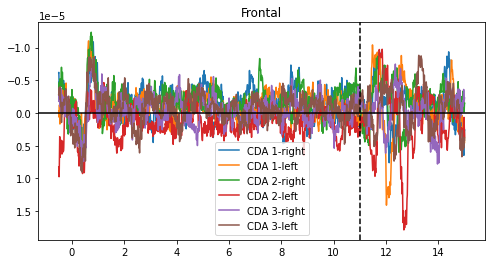

Subject Subject_T18M1_cleanAR Done! (26.82s)
Loading: Subject_T23F1_cleanAR.pkl...
79 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


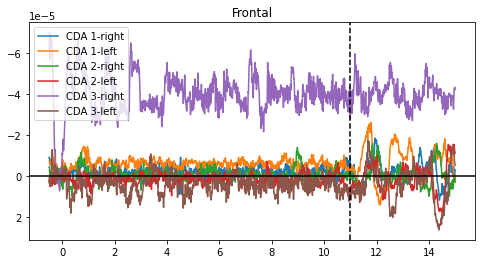

Subject Subject_T23F1_cleanAR Done! (26.16s)
Loading: Subject_T23F2_cleanAR.pkl...
81 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


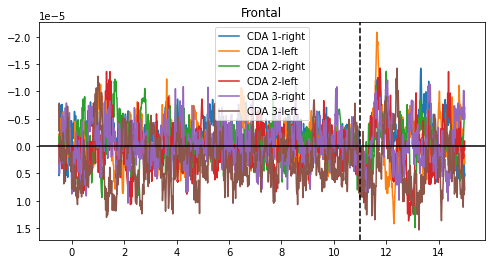

Subject Subject_T23F2_cleanAR Done! (27.23s)
Loading: Subject_T25F1_cleanAR.pkl...
84 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


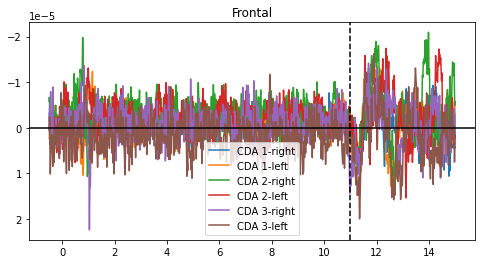

Subject Subject_T25F1_cleanAR Done! (28.04s)
Loading: Subject_T9F2_cleanAR.pkl...
50 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


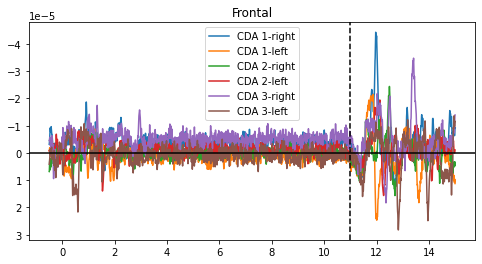

Subject Subject_T9F2_cleanAR Done! (17.27s)
Loading: Subject_W10F2_cleanAR.pkl...
70 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


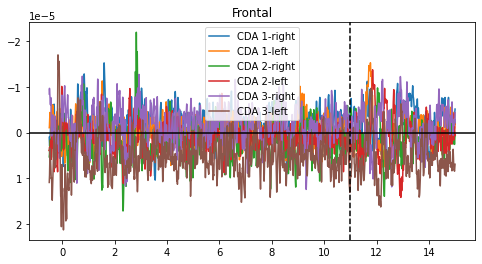

Subject Subject_W10F2_cleanAR Done! (24.15s)
Loading: Subject_W17M2_cleanAR.pkl...
83 epochs loaded.
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)

Applying baseline correction (mode: mean)


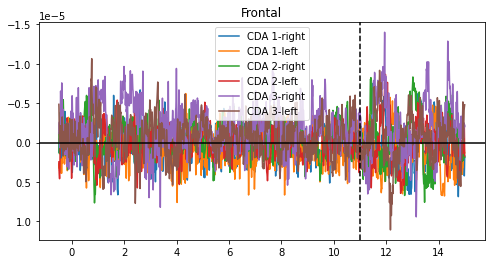

Subject Subject_W17M2_cleanAR Done! (28.23s)


In [125]:
CDA_ss_all = dict()   # CDA for Set Sizes

#=============================================================================
# Main Loop - Loading Files 1 by 1 to get CDA per Cluster per Subject.
#=============================================================================
for filepath in glob.iglob(directory_preproc + 'cleanAR\\Subject_*_cleanAR.pkl'):
    filename = filepath[filepath.rfind('\\')+1:]
    CDA_ss_all[filename] = dict()
    
    tic = time.time()
    print(f'Loading: {filename}...')

    with open(filepath, "rb") as f:
        data_pickle = pickle.load(f)

    epochs = data_pickle['epochs']
    print('{} epochs loaded.'.format(len(epochs)))
    
    epochs = epochs.filter(1, 30)
    epochs = epochs.apply_baseline(baseline=(-0.2, -0.0))

    perf = 'good'
        
    # Get Left and Right Channel in the cluster.
    clusters_chs_right = []
    clusters_chs_left = []
    for ch in clusters_chs['Frontal']:
        if ch[-1] != 'z':
            if int(ch[-1]) % 2 == 0:
                clusters_chs_right.append(ch)
            else:
                clusters_chs_left.append(ch)
    
    plt.figure(figsize=(8, 4))
    
    for size in conds:
        CDA_ss_all[filename][size] = dict()
        for side in sides:
            CDA_ss_all[filename][size] = []
            
            e_filter = size + '/' + side + '/' + perf
            try:
                cur_evoked_1 = epochs[e_filter].copy().pick_channels(clusters_chs_right).crop(tmin=-0.5, tmax=15).average()
                cur_evoked_2 = epochs[e_filter].copy().pick_channels(clusters_chs_left).crop(tmin=-0.5, tmax=15).average()
                if side == 'right':
                    cur_cda = (np.mean(cur_evoked_2.get_data(), 0) - np.mean(cur_evoked_1.get_data(), 0))
                elif side == 'left':
                    cur_cda = (np.mean(cur_evoked_1.get_data(), 0) - np.mean(cur_evoked_2.get_data(), 0))
                else:
                    continue
                    
                CDA_ss_all[filename][size][side] = cur_cda

                times = cur_evoked_1.times

                plt.plot(times, cur_cda, label=f'CDA {size}-{side}')

            except:
                print(f'Skipping... {filename} - {size} - {side}')
                
    plt.axvline(x=11, color ='k', linestyle='--')
    plt.axhline(y=0, color ='k', linestyle='-')
    plt.gca().invert_yaxis()
    plt.title(cur_cluster)
    plt.legend()
    plt.show()
    
    # Try to clear memory. It shouldn't change anything as I am re-allocating that space, but can't be bad...
    del data_pickle
    del epochs
    
    toc = time.time()
    print('Subject {} Done! ({:.2f}s)'.format(filename[:-4], toc-tic))


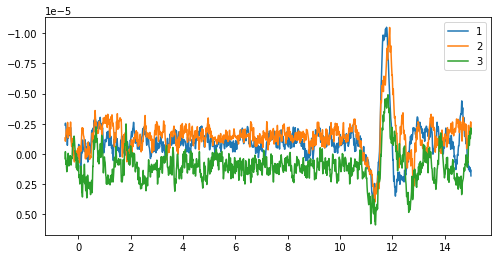

In [140]:
cda_ss = dict()
for size in conds:
    cda_ss[size] = []

for participant in CDA_ss_all.keys():
    if participant == 'Subject_F5M1_cleanAR.pkl':
        continue
    for size in conds:
        cda_ss[size].append(CDA_ss_all[participant][size])
    
fig = plt.figure(figsize=(8,4))
for size in conds:
    cda_ss[size] = np.stack(cda_ss[size])
    plt.plot(times, np.mean(cda_ss[size], 0), label=size)

plt.gca().invert_yaxis()
plt.legend()
plt.show()

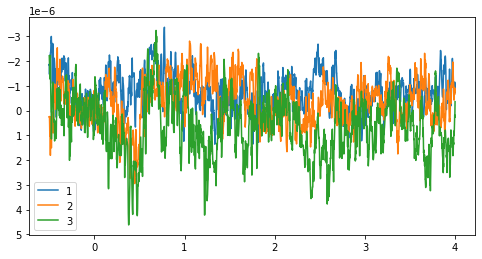

In [141]:
cda_ss = dict()
for size in conds:
    cda_ss[size] = []

for participant in CDA_ss_all.keys():
    if participant == 'Subject_F5M1_cleanAR.pkl':
        continue
    for size in conds:
        cda_ss[size].append(CDA_ss_all[participant][size])
    
fig = plt.figure(figsize=(8,4))
for size in conds:
    cda_ss[size] = np.stack(cda_ss[size])
    plt.plot(times[times < 4], np.median(cda_ss[size], 0)[times < 4], label=size)

plt.gca().invert_yaxis()
plt.legend()
plt.show()

# SS Tests

Skipping...
Skipping...


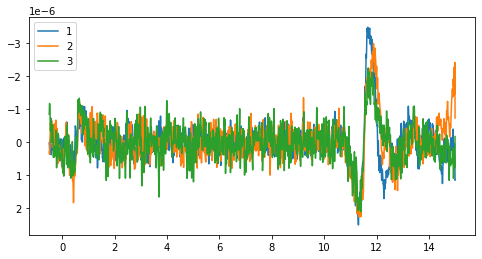

In [41]:
fig = plt.figure(figsize=(8, 4))

for size in conds:
    cda = []
    for participant in CDA_ss_all.keys():
        try:
            cda.append(CDA_ss_all[participant]['Central'][size]['left'])
        except:
            print('Skipping...')
        try:
            cda.append(CDA_ss_all[participant]['Central'][size]['right'])
        except:
            print('Skipping...')

    cda = np.stack(cda)
    cda_mean = np.mean(cda, 0)
    
    plt.plot(times, cda_mean, label=size)
    
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Skipping...
Skipping...


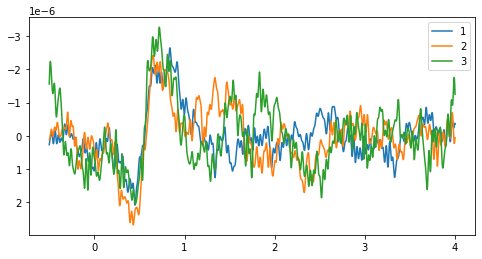

In [45]:
fig = plt.figure(figsize=(8, 4))

for size in conds:
    cda = []
    for participant in CDA_ss_all.keys():
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['left'])
        except:
            print('Skipping...')
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['right'])
        except:
            print('Skipping...')

    cda = np.stack(cda)
    cda_mean = np.mean(cda, 0)
    
    plt.plot(times[times <= 4], cda_mean[times <= 4], label=size)
    
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Skipping...
Skipping...


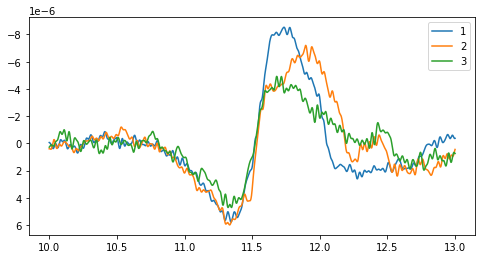

In [46]:
fig = plt.figure(figsize=(8, 4))

for size in conds:
    cda = []
    for participant in CDA_ss_all.keys():
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['left'])
        except:
            print('Skipping...')
        try:
            cda.append(CDA_ss_all[participant]['Frontal'][size]['right'])
        except:
            print('Skipping...')

    cda = np.stack(cda)
    cda_mean = np.mean(cda, 0)
    
    plt.plot(times[(times >= 10) & (times <= 13)], cda_mean[(times >= 10) & (times <= 13)], label=size)
    
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Skipping: Subject_F5M1_cleanAR.pkl:Frontal:3:left
Skipping: Subject_F26F2_cleanAR.pkl:Frontal:3:right


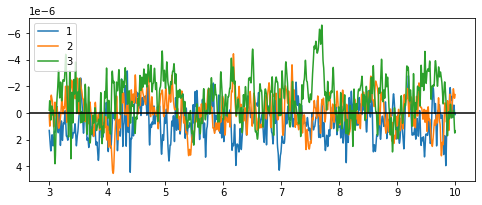

Skipping: Subject_F5M1_cleanAR.pkl:Central:3:left
Skipping: Subject_F26F2_cleanAR.pkl:Central:3:right


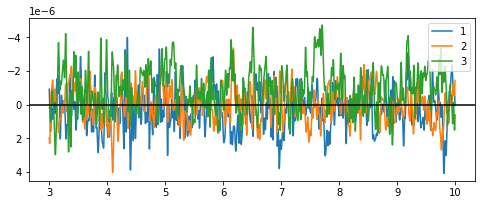

Skipping: Subject_F5M1_cleanAR.pkl:Temporal:3:left
Skipping: Subject_F26F2_cleanAR.pkl:Temporal:3:right


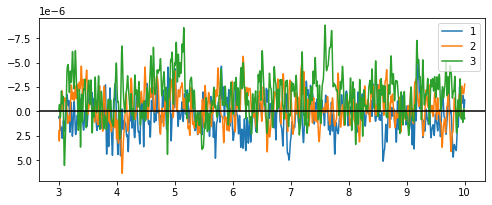

Skipping: Subject_F5M1_cleanAR.pkl:Parietal:3:left
Skipping: Subject_F26F2_cleanAR.pkl:Parietal:3:right


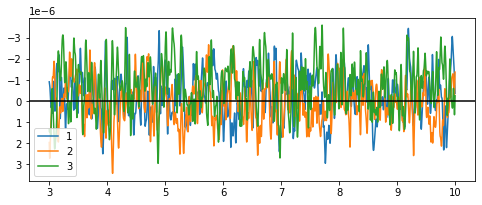

Skipping: Subject_F5M1_cleanAR.pkl:Occipital:3:left
Skipping: Subject_F26F2_cleanAR.pkl:Occipital:3:right


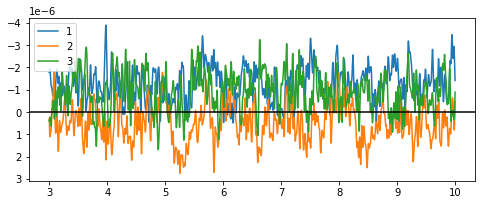

In [66]:
#time_window = (times >= 11) & (times <= 14)
#time_window = (times >= -0.2) & (times <= 6)
time_window = (times >= 3) & (times <= 10)

cda_mean_right = dict()
cda_mean_left = dict()
for cur_cluster in clusters_chs.keys(): 
    plt.figure(figsize=(8,3))
    cda_mean_right[cur_cluster] = dict()
    cda_mean_left[cur_cluster] = dict()
    cda_stacked = dict()
    cda_stacked_left = dict()
    cda_stacked_right = dict()
    
    for size in conds:
        cda_stacked_left[size] = []
        cda_stacked_right[size] = []
        cda_mean_right[cur_cluster][size] = []
        cda_mean_left[cur_cluster][size] = []
        
        for participant in CDA_ss_all.keys():
            cda_stacked[size] = []
            try:
                cur_data = CDA_ss_all[participant][cur_cluster][size]['left']
                #cur_data_bled = cur_data - np.mean(cur_data)
                cda_stacked[size].append(cur_data)
            except:
                print(f'Skipping: {participant}:{cur_cluster}:{size}:left')
        cda_stacked_left[size] = np.stack(cda_stacked[size])
        for participant in CDA_ss_all.keys():
            cda_stacked[size] = []
            try:
                cur_data = CDA_ss_all[participant][cur_cluster][size]['right']
                #cur_data_bled = cur_data - np.mean(cur_data)
                cda_stacked[size].append(cur_data)
            except:
                print(f'Skipping: {participant}:{cur_cluster}:{size}:right')
        cda_stacked_right[size] = np.stack(cda_stacked[size])

        cda_mean_right[cur_cluster][size] = np.mean(cda_stacked_right[size], 0)
        cda_mean_left[cur_cluster][size] = np.mean(cda_stacked_left[size], 0)
   
        plt.plot(times[time_window], (cda_mean_right[cur_cluster][size][time_window] + cda_mean_left[cur_cluster][size][time_window])/2, label=size)
    
    #plt.axvline(x=11, color ='k', linestyle='--')
    plt.axhline(y=0, color ='k', linestyle='-')
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()